# Project 2

It is October 2018. The squirrels in Central Park are running into a problem and we need your help.

For this project you must go through most steps in the checklist. You must write responses for all items however sometimes the item will simply be "does not apply". Some of the parts are a bit more nebulous and you simply show that you have done things in general (and the order doesn't really matter). Keep your progress and thoughts organized in this document and use formatting as appropriate (using markdown to add headers and sub-headers for each major part). Do not do the final part (launching the product) and your presentation will be done as information written in this document in a dedicated section, no slides or anything like that. It should however include the best summary plots/graphics/data points.

You are intentionally given very little information thus far. You must communicate with your client (me) for additional information as necessary. But also make sure that your communications are efficient, thought out, and not redundant as your client might get frustrated and "fire" you (this only applies to getting information from your client, this does not necessary apply to asking for help with the actual project itself - you should continuously ask questions for getting help).

You must submit all data files and a pickled preprocessor and final model along with this notebook.

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.neighbors import RadiusNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cluster import DBSCAN
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, precision_recall_curve, roc_curve, auc
from sklearn.ensemble import GradientBoostingClassifier

#from xgboost import XGBClassifier

Frame the Problem and Look at the Big Picture
========================

1. **Define the objective in business terms.**
   - The objective is to develop a predictive model to identify potentially sick squirrels in Central Park from reported sightings, enabling the client to respond quickly to disease risks. The model should help prevent squirrel disease spread, preserving this critical ecological component by prioritizing intervention for identified sick individuals.

2. **How will your solution be used?**
   - The model will provide online predictions, flagging sightings that likely indicate sickness based on specific patterns. These flagged sightings will trigger response actions, helping the client or park rangers identify which squirrels need attention, ideally catching every sick squirrel to mitigate any spread.

3. **What are the current solutions/workarounds (if any)?**
   - Currently, sightings are reported by people, but there's no predictive mechanism to evaluate the health status of observed squirrels. Without this model, decisions might rely on manual assessments or sporadic checks, which may not consistently or accurately detect health risks.

4. **How should you frame this problem (supervised/unsupervised, online/offline, …)?**
   - This is a **supervised, binary classification** problem. We aim to classify sightings as "sick" or "not sick," based on labeled data or inferred from characteristics. Since the client needs ongoing predictions, an **online** learning model would be appropriate if data is continuously fed.

5. **How should performance be measured? Is the performance measure aligned with the business objective?**
   - **Precision and Recall** should be fairly balanced, as the client aims to catch every sick squirrel. However, we also want a high precision because of the low budget of the client. This leads us to look for a balance between both. We want to try and get most of the diseased squirrels labeled as diseased, but we also want to be pretty confident that the squirrels that are looked at are actually diseased so that we dont waste resources.

6. **What would be the minimum performance needed to reach the business objective?**
   - A minimum recall threshold of perhaps **90-95%** could be necessary, given the critical nature of detecting all potential sickness cases. The model may tolerate some level of false positives, but it should rarely miss any cases of sick squirrels.

7. **What are comparable problems? Can you reuse experience or tools?**
   - This problem is similar to **medical screening** or **wildlife monitoring** models, where high recall is critical to prevent issues like disease outbreaks. Techniques used in health diagnostics or ecological monitoring, like anomaly detection, high-recall classifiers, and time-series analysis, might be applicable.

8. **Is human expertise available?**
   - Not as of currently.

9. **How would you solve the problem manually?**
   - I would focus on specific symptoms and actions from the squirrels. I would also focus on working with weather data as weather could play a part in squirrel sickness.

10. **List the assumptions you (or others) have made so far. Verify assumptions if possible.**
    - **Assumptions**:
      - The sightings data includes identifiable indicators of sickness.


Get the Data
=======================================================================

1. **List the data you need and how much you need.** 
    - We need data to predict either sick, or not sick. To do that we need New York Central Park squirrel census from 2018. We would also need label data to know whether the squirrels are sick or not. We would also need weather data to identify any correlation. 
2. **Find and document where you can get that data:** 
    - From the client the diseased squirrels dataset. 
    - `https://data.cityofnewyork.us/Environment/2018-Central-Park-Squirrel-Census-Squirrel-Data/vfnx-vebw/about_data`
    - `https://www.wunderground.com/history/monthly/us/ny/new-york-city/KNYC/date/2018-10`
3. **Get access authorizations:** 
    - Done
4. **Create a workspace (with enough storage space):**
    - This notebook.
5. **Get the data:** 
    - Got the data
6. **Convert the data to a format you can easily manipulate (without changing the data itself):** 
    - Done, it's a CSV.
7. **Ensure sensitive information is deleted or protected (e.g. anonymized):** 
    - Done
8. **Check the size and type of data (time series, geographical, …):** 
    - <mark>DONE</mark>
9. **Sample a test set, put it aside, and never look at it (no data snooping!):** 
    - <mark>DONE</mark> 

In [11]:
def merge_data():
    """
    Prepares and merges two datasets: a diseased squirrel dataset and the Central Park squirrel census data.
    
    - Reads the diseased squirrel data from 'diseased_squirrels.csv' with a single column labeled 'Unique Squirrel ID'.
    - Reads the Central Park squirrel census data from '2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20241104.csv'.
    - Checks if the columns 'Unique Squirrel ID' exist in both datasets.
    - Creates a 'Diseased' column in the census data (df2) by checking if each squirrel in df2's 'Unique Squirrel ID' column
      is present in the diseased squirrel dataset (df1).
    - Saves the updated census data with the 'Diseased' column to 'merged_data.csv'.
    
    Raises:
        KeyError: If 'Unique Squirrel ID' is not found in one of the dataframes.
    """
    # read data
    df1 = pd.read_csv('diseased_squirrels.csv', header=None, names=['Unique Squirrel ID'])
    df2 = pd.read_csv('2018_Central_Park_Squirrel_Census_-_Squirrel_Data_20241104.csv')

    # check column names
    print(df1.columns)
    print(df2.columns)

    # ensure column names match
    if 'Unique Squirrel ID' in df1.columns and 'Unique Squirrel ID' in df2.columns:
        # create a 'Diseased' column in df2
        df2['Diseased'] = df2['Unique Squirrel ID'].isin(df1['Unique Squirrel ID'])
    else:
        raise KeyError("Column 'Unique Squirrel ID' not found in one of the dataframes")
        
    # save data
    df2.to_csv('merged_data.csv', index=False)

merge_data()

def merge_squirrel_weather_data(squirrel_data, weather):
    """
    Merges squirrel sighting data with weather data based on the date.
    
    Parameters:
        squirrel_data (DataFrame): DataFrame containing squirrel sightings data with a 'Date' column.
        weather (DataFrame): DataFrame containing weather data with a 'Time' column in MM-DD format.
    
    - Converts the 'Date' column in the squirrel sightings data to a datetime format.
    - Converts the 'Time' column in the weather data to a datetime format and applies the year 2018.
    - Merges the squirrel data and weather data on the 'Date' column with a left join.
    
    Returns:
        DataFrame: A combined DataFrame with squirrel sightings and corresponding weather data.
    """
    # Convert the Date column in squirrel_data to datetime format
    squirrel_data['Date'] = pd.to_datetime(squirrel_data['Date'], format='%m%d%Y')

    # Convert the Time column in weather to datetime format
    weather['Date'] = pd.to_datetime(weather['Time'], format='%d').apply(lambda x: x.replace(month=10, year=2018))

    # Merge the dataframes on the Date column
    combined_data = pd.merge(squirrel_data, weather, on='Date', how='left')

    # Display the first few rows of the combined dataframe
    return combined_data

squirrel_data = pd.read_csv('merged_data.csv')
weather = pd.read_csv('October_weather_data.csv')

data = merge_squirrel_weather_data(squirrel_data, weather)



class SingleColumnBinaryTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer to make any columns that I want to be binary binary.
    """
    def __init__(self, column, positive_value):
        self.column = column
        self.positive_value = positive_value

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        binary_feature = np.where(X[self.column] == self.positive_value, 1, 0)
        return pd.DataFrame(binary_feature, columns=[f"{self.column}_binary"])

    # Add get_feature_names_out for compatibility with pipelines
    def get_feature_names_out(self, input_features=None):
        return [f"{self.column}_binary"]
    


class HighlightFurColorTransformer(BaseEstimator, TransformerMixin):
    """
    Transformer for the 'Highlight Fur Color' column that creates binary columns for each color. 
    Basically it one hot encodes all of the colors so that if a squirrel has multiple colors it 
    shows up on 2 separate columns.
    """
    def __init__(self):
        self.valid_colors = ['Black', 'White', 'Gray', 'Cinnamon']
        
    def fit(self, X, y=None):
        return self  # No fitting necessary for this transformation

    def transform(self, X):
        X['Highlight Fur Color_Black'] = X['Highlight Fur Color'].apply(
            lambda x: 1 if 'Black' in x else 0)
        X['Highlight Fur Color_White'] = X['Highlight Fur Color'].apply(
            lambda x: 1 if 'White' in x else 0)
        X['Highlight Fur Color_Gray'] = X['Highlight Fur Color'].apply(
            lambda x: 1 if 'Gray' in x else 0)
        X['Highlight Fur Color_Cinnamon'] = X['Highlight Fur Color'].apply(
            lambda x: 1 if 'Cinnamon' in x else 0)
        
        # Drop the original 'Highlight Fur Color' column
        return X.drop(columns=['Highlight Fur Color'])

    def get_feature_names_out(self, input_features=None):
        # Return the names of the new binary columns including "Unknown"
        return [
            'Highlight Fur Color_Black',
            'Highlight Fur Color_White',
            'Highlight Fur Color_Gray',
            'Highlight Fur Color_Cinnamon',
            'Highlight Fur Color_Unknown'  # New column for unknown colors
        ]
    



class HotspotsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, eps=0.0002, min_samples=2):
        self.eps = eps
        self.min_samples = min_samples
        self.cluster_centers_ = None

    def fit(self, X, y=None):
        if y is None:
            raise ValueError("The target variable y with 'Diseased' information must be provided for HotspotsTransformer.")

        # Ensure X is an array and use numeric indexing if needed
        diseased_coords = X[y == 1][:, [0, 1]]  # Use appropriate indices for 'X' and 'Y' columns

        # Apply DBSCAN clustering
        dbscan = DBSCAN(eps=self.eps, min_samples=self.min_samples)
        diseased_clusters = dbscan.fit_predict(diseased_coords)

        # Compute cluster centers as before
        cluster_centers = []
        for cluster in set(diseased_clusters):
            if cluster != -1:
                cluster_points = diseased_coords[diseased_clusters == cluster]
                cluster_center = cluster_points.mean(axis=0)
                cluster_centers.append(cluster_center)

        self.cluster_centers_ = np.array(cluster_centers)
        return self

    def transform(self, X):
        # Calculate the distance from each squirrel to the nearest diseased squirrel cluster
        if self.cluster_centers_ is not None and len(self.cluster_centers_) > 0:
            nbrs = NearestNeighbors(n_neighbors=1).fit(self.cluster_centers_)
            distances, _ = nbrs.kneighbors(X[:, [0, 1]])  # Use correct indices for 'X' and 'Y'

            X = X.copy()  # Avoid modifying the original X
            # Append inverse distances to X
            inverse_distances = 1 / (distances + 1e-6)  # Adding epsilon to avoid division by zero
            X = inverse_distances

        else:
            # Use fallback values that won’t disrupt calculations downstream
            fallback_inverse = 1e-6  # A small finite value instead of 0
            inverse_distances = fallback_inverse * np.ones((X.shape[0], 1))
            X = inverse_distances

        return X

class DropColumnsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns  # List of columns to drop

    def fit(self, X, y=None):
        # No fitting needed, simply return self
        return self

    def transform(self, X):
        # Drop the specified columns
        return X.drop(columns=self.columns, errors='ignore')
    
class BinaryBehaviorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, behavior_columns):
        # Initialize with the list of behavior columns
        self.behavior_columns = behavior_columns

    def fit(self, X, y=None):
        # No fitting is needed since we are just transforming the data
        return self

    def transform(self, X):
        # Convert the specified behavior columns to binary (1 for non-zero, 0 for zero or NaN)
        X[self.behavior_columns] = X[self.behavior_columns].notna().astype(int)
        return X

Index(['Unique Squirrel ID'], dtype='object')
Index(['X', 'Y', 'Unique Squirrel ID', 'Hectare', 'Shift', 'Date',
       'Hectare Squirrel Number', 'Age', 'Primary Fur Color',
       'Highlight Fur Color', 'Combination of Primary and Highlight Color',
       'Color notes', 'Location', 'Above Ground Sighter Measurement',
       'Specific Location', 'Running', 'Chasing', 'Climbing', 'Eating',
       'Foraging', 'Other Activities', 'Kuks', 'Quaas', 'Moans', 'Tail flags',
       'Tail twitches', 'Approaches', 'Indifferent', 'Runs from',
       'Other Interactions', 'Lat/Long'],
      dtype='object')


In [12]:
data.info(show_counts=True)
data['Diseased'].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3023 entries, 0 to 3022
Data columns (total 49 columns):
 #   Column                                      Non-Null Count  Dtype         
---  ------                                      --------------  -----         
 0   X                                           3023 non-null   float64       
 1   Y                                           3023 non-null   float64       
 2   Unique Squirrel ID                          3023 non-null   object        
 3   Hectare                                     3023 non-null   object        
 4   Shift                                       3023 non-null   object        
 5   Date                                        3023 non-null   datetime64[ns]
 6   Hectare Squirrel Number                     3023 non-null   int64         
 7   Age                                         2902 non-null   object        
 8   Primary Fur Color                           2968 non-null   object        
 9   Highligh

Diseased
False    2701
True      322
Name: count, dtype: int64

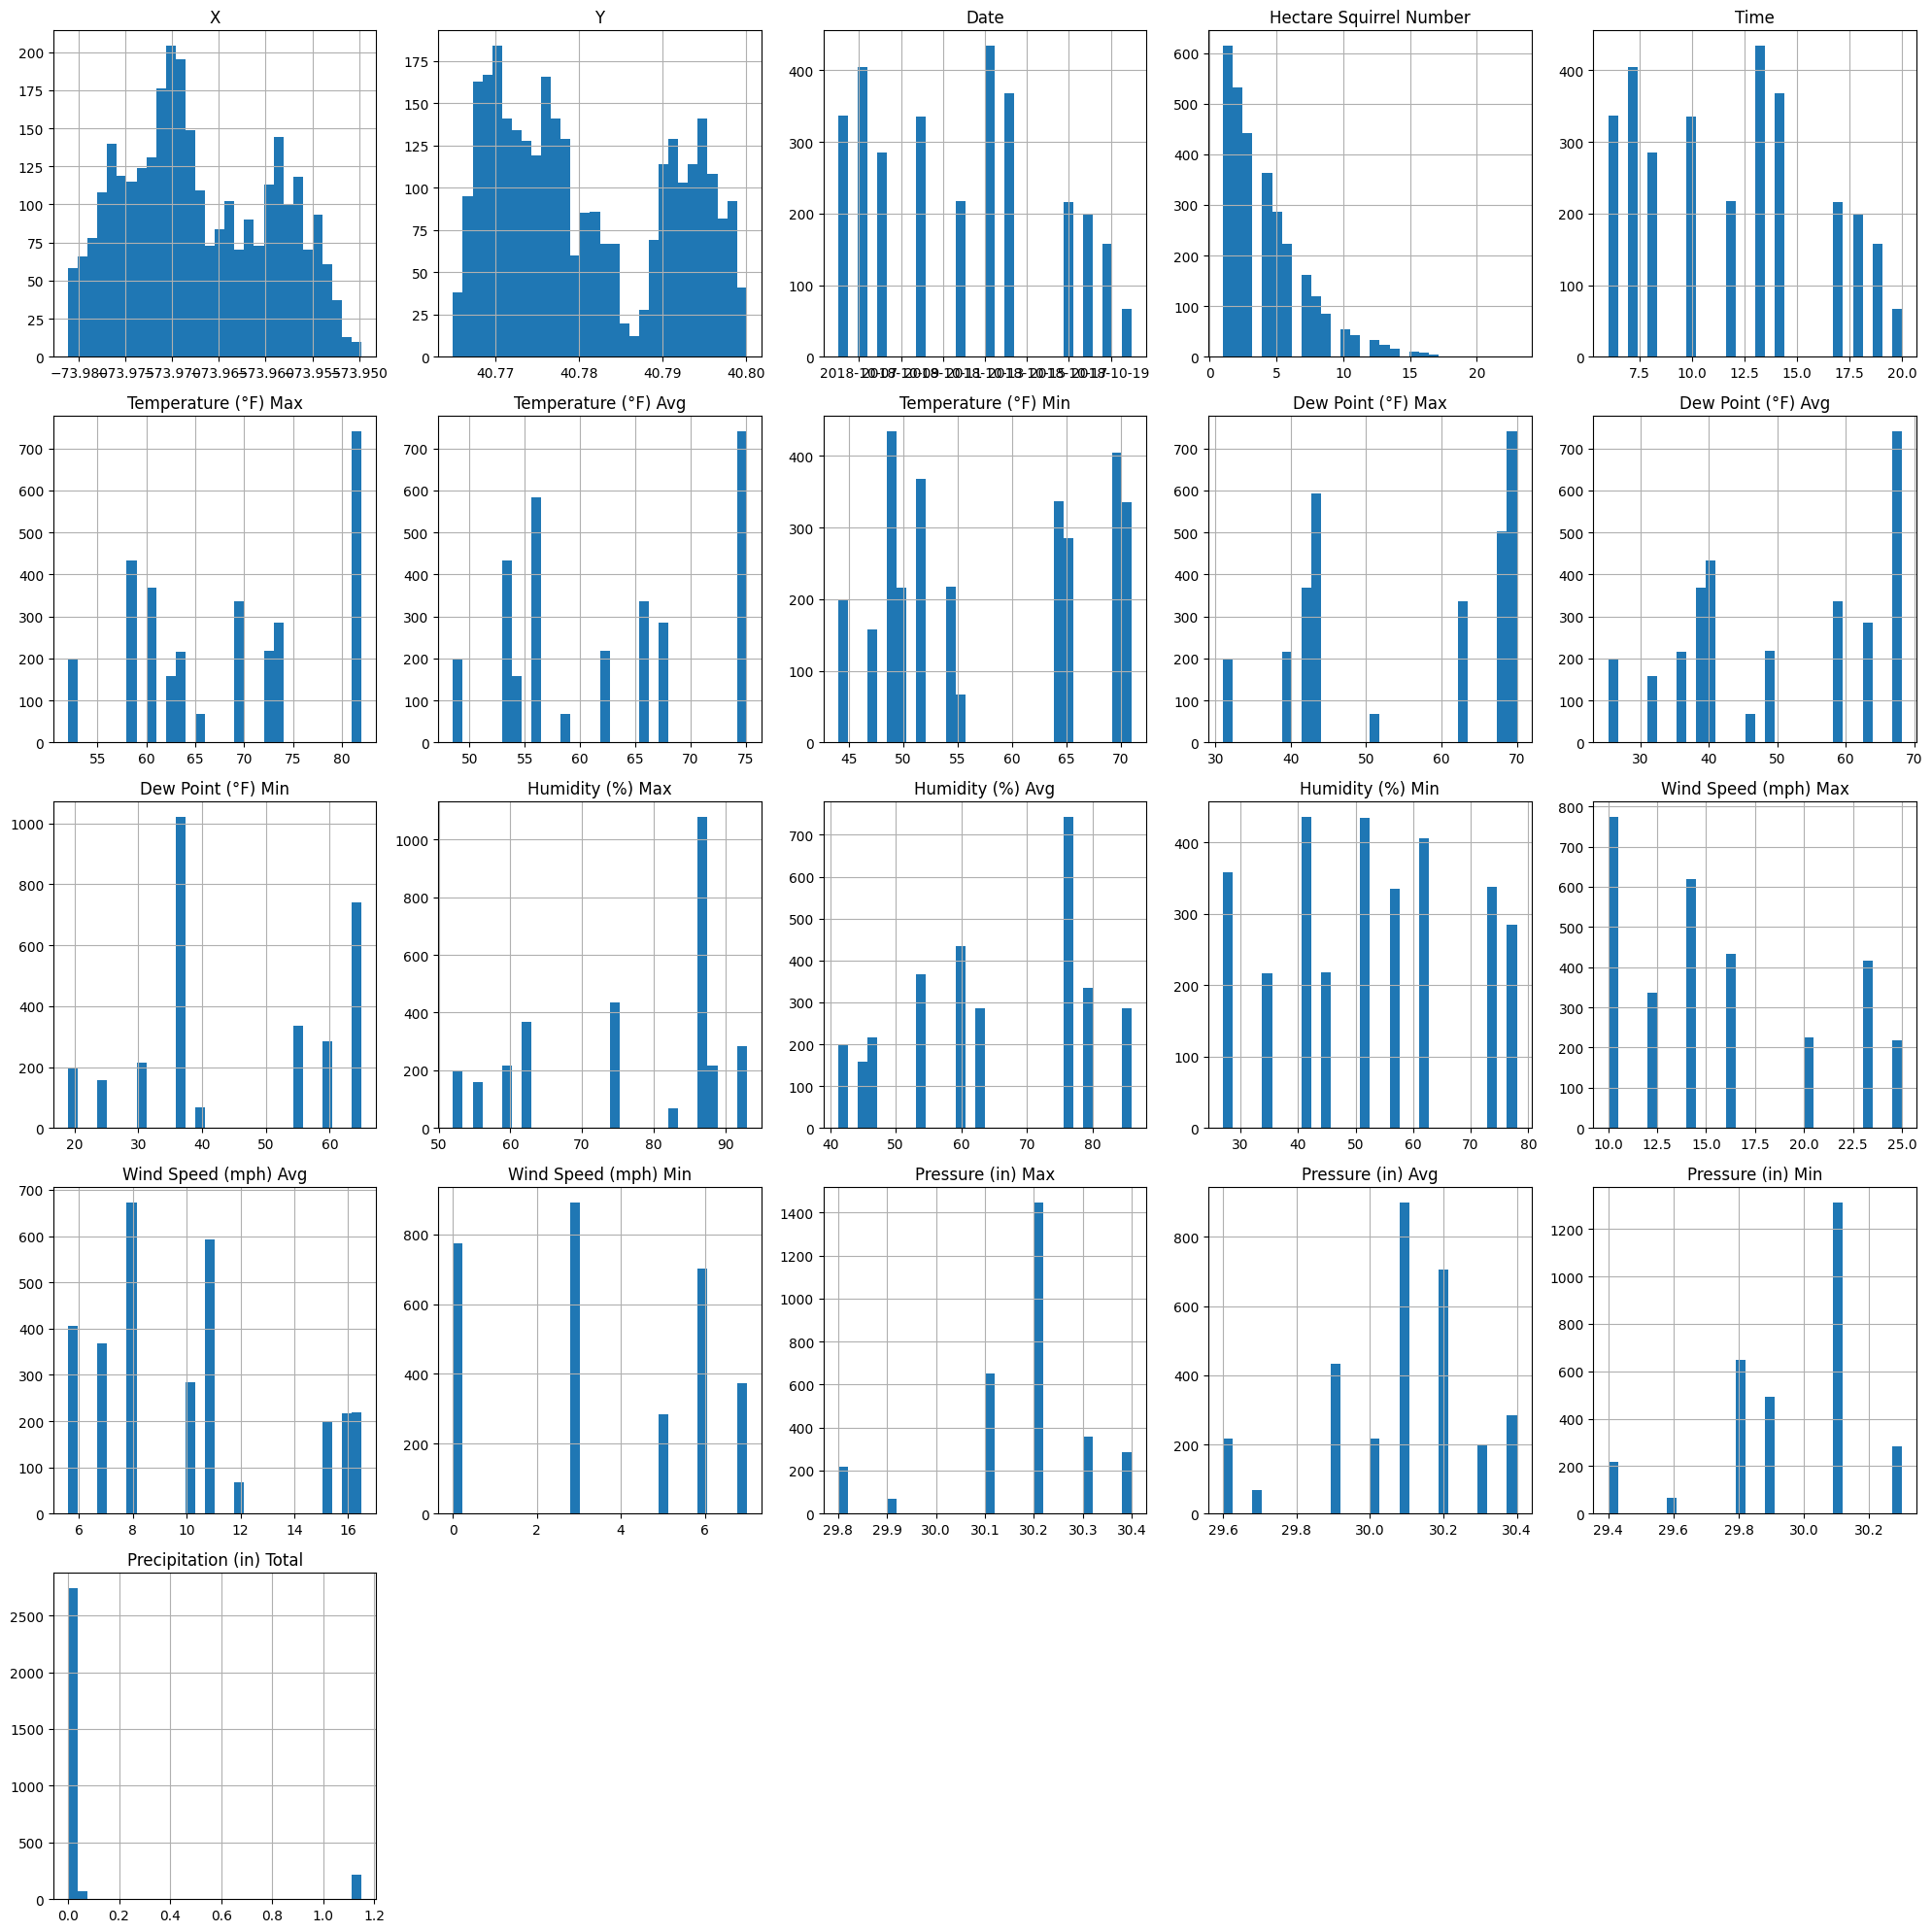

In [13]:
data.hist(figsize=(20, 20), bins=30)
plt.tight_layout()
plt.show()

In [14]:
# Extract boolean columns
boolean_columns = data.select_dtypes(include='bool').columns

# Calculate the proportion of True and False values for each boolean feature
boolean_summary = data[boolean_columns].apply(lambda x: x.value_counts(normalize=True)).T
boolean_summary.columns = ['False', 'True']

print(boolean_summary)

                  False      True
Running        0.758518  0.241482
Chasing        0.907708  0.092292
Climbing       0.782335  0.217665
Eating         0.748594  0.251406
Foraging       0.525306  0.474694
Kuks           0.966259  0.033741
Quaas          0.983460  0.016540
Moans          0.999008  0.000992
Tail flags     0.948726  0.051274
Tail twitches  0.856434  0.143566
Approaches     0.941118  0.058882
Indifferent    0.519021  0.480979
Runs from      0.775719  0.224281
Diseased       0.893483  0.106517


### Behavioral Feature Stratification Analysis

**Heavily Imbalanced Features**:
   - Features like `Kuks`, `Quaas`, `Moans`, and `Tail flags` are highly imbalanced, with few True values.
   - **Stratifying these features** may enhance model performance by ensuring adequate representation of both states, especially if these behaviors relate to sickness.

**Moderately Imbalanced Features**:
   - `Climbing`, `Eating`, `Tail twitches`, and `Runs from` show moderate imbalance. Consider stratifying these if they correlate with the target, though it's less critical than for heavily imbalanced features.

**Balanced Features**:
   - `Foraging` and `Indifferent` are well-balanced between True and False, so stratification is likely unnecessary.

**Target Label - Diseased**:
   - `Diseased` is moderately imbalanced, with True cases around 10.6%.


In [15]:
from scipy.stats import chi2_contingency

# Extract object columns
object_columns = data.select_dtypes(include='object').columns

# Function to perform chi-square test
def chi_square_test(data, object_columns, target):
    chi2_results = {}
    for col in object_columns:
        contingency_table = pd.crosstab(data[col], data[target])
        chi2, p, dof, ex = chi2_contingency(contingency_table)
        chi2_results[col] = {'chi2': chi2, 'p-value': p}
    return chi2_results

# Perform chi-square test
chi2_results = chi_square_test(data, object_columns, 'Diseased')

# Display the results
for col, result in chi2_results.items():
    print(f"Feature: {col}, Chi2: {result['chi2']}, p-value: {result['p-value']}")

Feature: Unique Squirrel ID, Chi2: 3022.9999999999995, p-value: 0.46582421236577864
Feature: Hectare, Chi2: 558.1316815698673, p-value: 4.720787340891054e-13
Feature: Shift, Chi2: 6.808624322270109e-06, p-value: 0.9979180549889929
Feature: Age, Chi2: 10.435804722551559, p-value: 0.00541868365409623
Feature: Primary Fur Color, Chi2: 1138.5172788862726, p-value: 5.944483338009056e-248
Feature: Highlight Fur Color, Chi2: 377.6592765783757, p-value: 7.961829841523003e-76
Feature: Combination of Primary and Highlight Color, Chi2: 1177.8680894100214, p-value: 3.1444250918913405e-236
Feature: Color notes, Chi2: 165.0708349926988, p-value: 0.03527359127715566
Feature: Location, Chi2: 2.728708899814244, p-value: 0.09855893167687874
Feature: Above Ground Sighter Measurement, Chi2: 32.00645671853988, p-value: 0.8120227997348299
Feature: Specific Location, Chi2: 364.7998397435897, p-value: 0.008557371025364233
Feature: Other Activities, Chi2: 327.1990784252297, p-value: 0.19360259984991715
Feature

### Chi-square Test Analysis for Feature Relevance to Target (Diseased)

This analysis assesses the association between each categorical feature and the target variable (`Diseased`) using the Chi-square test of independence. The Chi-square statistic (`chi2`) and p-value are reported for each feature, helping to identify features that may have predictive value.

#### Key Findings

1. **Significant Features (p-value < 0.05)**
   - **Hectare** (Chi2: 558.13, p-value: 4.72e-13): Indicates a strong association with `Diseased`, suggesting that squirrel density by park section could be relevant for predicting sickness.
   - **Primary Fur Color** (Chi2: 1138.52, p-value: 5.94e-248) and **Highlight Fur Color** (Chi2: 377.66, p-value: 7.96e-76): These fur color features have significant associations with the target, implying that certain fur colors may be indicators of sickness.
   - **Combination of Primary and Highlight Color** (Chi2: 1177.87, p-value: 3.14e-236): This combination is also strongly associated with `Diseased`, reinforcing the relevance of color attributes in the model.
   - **Color Notes** (Chi2: 165.07, p-value: 0.035): Although less strongly, this feature shows a significant association, indicating some potential relevance.
   - **Age** (Chi2: 10.44, p-value: 0.005): Suggests that age group may be relevant, with differences in sickness incidence between juveniles and adults.

   These features should be prioritized in the model and considered for stratification to ensure diverse representation across significant categories.

2. **Non-significant Features (p-value > 0.05)**
   - **Unique Squirrel ID** (p-value: 0.47) and **Shift (AM/PM)** (p-value: 0.99): These features show no significant association with `Diseased`, suggesting minimal predictive value.
   - **Lat/Long** (p-value: 0.49), **Location** (p-value: 0.10), and **Other Interactions** (p-value: 0.22): These features also lack statistical significance, indicating they may not contribute meaningful insights into the target label.

### Results

Based on the Chi-square test results:
   - **Include** significant features like `Hectare`, `Primary Fur Color`, `Highlight Fur Color`, and `Combination of Primary and Highlight Color`, as they show strong associations with the target and may enhance model accuracy.
   - **Exclude** non-significant features such as `Unique Squirrel ID`, `Shift`, and `Lat/Long`, as they are unlikely to impact the target variable.



In [16]:
# Function to calculate the proportion of each category in object columns
def calculate_proportions(data, object_columns):
    proportions = {}
    for col in object_columns:
        proportions[col] = data[col].value_counts(normalize=True)
    return proportions

# Calculate proportions for object columns
object_proportions = calculate_proportions(data, object_columns)

# Display the proportions
for col, prop in object_proportions.items():
    print(f"Proportions for {col}:\n{prop}\n")

# Determine if stratification is needed based on the proportions
stratify_columns = [col for col, prop in object_proportions.items() if prop.max() > 0.75]
print(f"Columns to stratify: {stratify_columns}")

Proportions for Unique Squirrel ID:
Unique Squirrel ID
7D-PM-1010-01     0.000662
40B-AM-1019-06    0.000662
37E-PM-1006-03    0.000662
4C-PM-1010-05     0.000662
1F-AM-1010-04     0.000662
                    ...   
13F-AM-1007-01    0.000331
12D-AM-1013-02    0.000331
2F-AM-1006-03     0.000331
9H-PM-1018-04     0.000331
5E-PM-1012-01     0.000331
Name: proportion, Length: 3018, dtype: float64

Proportions for Hectare:
Hectare
14D    0.010586
32E    0.009924
14E    0.009262
01B    0.008932
07H    0.008601
         ...   
11C    0.000331
23D    0.000331
26B    0.000331
24B    0.000331
30F    0.000331
Name: proportion, Length: 339, dtype: float64

Proportions for Shift:
Shift
PM    0.554416
AM    0.445584
Name: proportion, dtype: float64

Proportions for Age:
Age
Adult       0.884907
Juvenile    0.113715
?           0.001378
Name: proportion, dtype: float64

Proportions for Primary Fur Color:
Primary Fur Color
Gray        0.833221
Cinnamon    0.132075
Black       0.034704
Name: proport

### Stratification

Despite seeing other imbalances within the data, we only need to stratify the 'diseased'. The other features are imbalanced but there are enough values within the features that we feel comfortable not having the need to stratify them. 

In [17]:
#train test split 
from sklearn.model_selection import train_test_split

X = data.drop('Diseased', axis=1)
y = data['Diseased']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

### Train Test Split Analysis
In analyzing the dataset, we found that the target label was highly imbalanced. To address this, we ensured that stratification was applied specifically to the target label during the train-test split process. Although we examined correlations for the other features, they demonstrated little to no correlation with the target label, and thus, stratification was only implemented for the target variable.


# Data Visualization

In [18]:
# create train set which has target and other columns
train = X_train.copy()
train['Diseased'] = y_train

In [19]:
# Convert all boolean columns to integers (0 and 1) for correlation checking
train = train.astype({col: 'int' for col in train.select_dtypes(include='bool').columns})

In [20]:
# make new Column for Age called Age_Adult and make it 1 for being Adult and 0 for not being adult

train['Age_Adult'] = train['Age'].apply(lambda x: 1 if x == 'Adult' else 0)

train['Age_Adult'].value_counts()

Age_Adult
1    2064
0     354
Name: count, dtype: int64

In [21]:
# make new Column for Age called Age_Juvenile and make it 1 for being Juvenile and 0 for not being Juvenile

train['Age_Juvenile'] = train['Age'].apply(lambda x: 1 if x == 'Juvenile' else 0)

train['Age_Juvenile'].value_counts()

Age_Juvenile
0    2154
1     264
Name: count, dtype: int64

In [23]:
# create new shift column Shift_Binary and make it 1 for being PM and 0 for being AM

train['Shift_Binary'] = train['Shift'].apply(lambda x: 1 if x == 'PM' else 0)

train['Shift_Binary'].value_counts()


Shift_Binary
1    1335
0    1083
Name: count, dtype: int64

In [24]:
# create new column for Primary Fur Color Gray

train['Primary Fur Color_Gray'] = train['Primary Fur Color'].apply(lambda x: 1 if x == 'Gray' else 0)

Gray= train['Primary Fur Color_Gray'].value_counts()

# create new column for Primary Fur Color Cinnamon

train['Primary Fur Color_Cinnamon'] = train['Primary Fur Color'].apply(lambda x: 1 if x == 'Cinnamon' else 0)

Cinnamon = train['Primary Fur Color_Cinnamon'].value_counts()

# create new column for Primary Fur Color Black

train['Primary Fur Color_Black'] = train['Primary Fur Color'].apply(lambda x: 1 if x == 'Black' else 0)

Black = train['Primary Fur Color_Black'].value_counts()

Gray, Cinnamon, Black

(Primary Fur Color_Gray
 1    1989
 0     429
 Name: count, dtype: int64,
 Primary Fur Color_Cinnamon
 0    2112
 1     306
 Name: count, dtype: int64,
 Primary Fur Color_Black
 0    2335
 1      83
 Name: count, dtype: int64)

In [25]:
# break up highlight fur color into new columns Black, White, Gray, Cinnamon. If the color is present, the value is 1

#in case there is NA values, fill them with empty string for separation
train['Highlight Fur Color'] = train['Highlight Fur Color'].fillna('').astype(str)

train['Highlight Fur Color_Black'] = train['Highlight Fur Color'].apply(lambda x: 1 if 'Black' in x else 0)

train['Highlight Fur Color_White'] = train['Highlight Fur Color'].apply(lambda x: 1 if 'White' in x else 0)

train['Highlight Fur Color_Gray'] = train['Highlight Fur Color'].apply(lambda x: 1 if 'Gray' in x else 0)

train['Highlight Fur Color_Cinnamon'] = train['Highlight Fur Color'].apply(lambda x: 1 if 'Cinnamon' in x else 0)

train['Highlight Fur Color_Black'].value_counts(), train['Highlight Fur Color_White'].value_counts(), train['Highlight Fur Color_Gray'].value_counts(), train['Highlight Fur Color_Cinnamon'].value_counts()

(Highlight Fur Color_Black
 0    2349
 1      69
 Name: count, dtype: int64,
 Highlight Fur Color_White
 0    1654
 1     764
 Name: count, dtype: int64,
 Highlight Fur Color_Gray
 0    2237
 1     181
 Name: count, dtype: int64,
 Highlight Fur Color_Cinnamon
 0    1535
 1     883
 Name: count, dtype: int64)

In [26]:
train['Location'].value_counts()

# create new column for Location Ground Plane and Above Ground. 1 is for being Above Ground and 0 for being Ground Plane

train['Location_Binary'] = train['Location'].apply(lambda x: 1 if x == 'Ground Plane' else 0)

train['Location_Binary'].value_counts()

Location_Binary
1    1690
0     728
Name: count, dtype: int64

In [27]:
#drop Unique Squirell ID

train = train.drop('Unique Squirrel ID', axis=1)

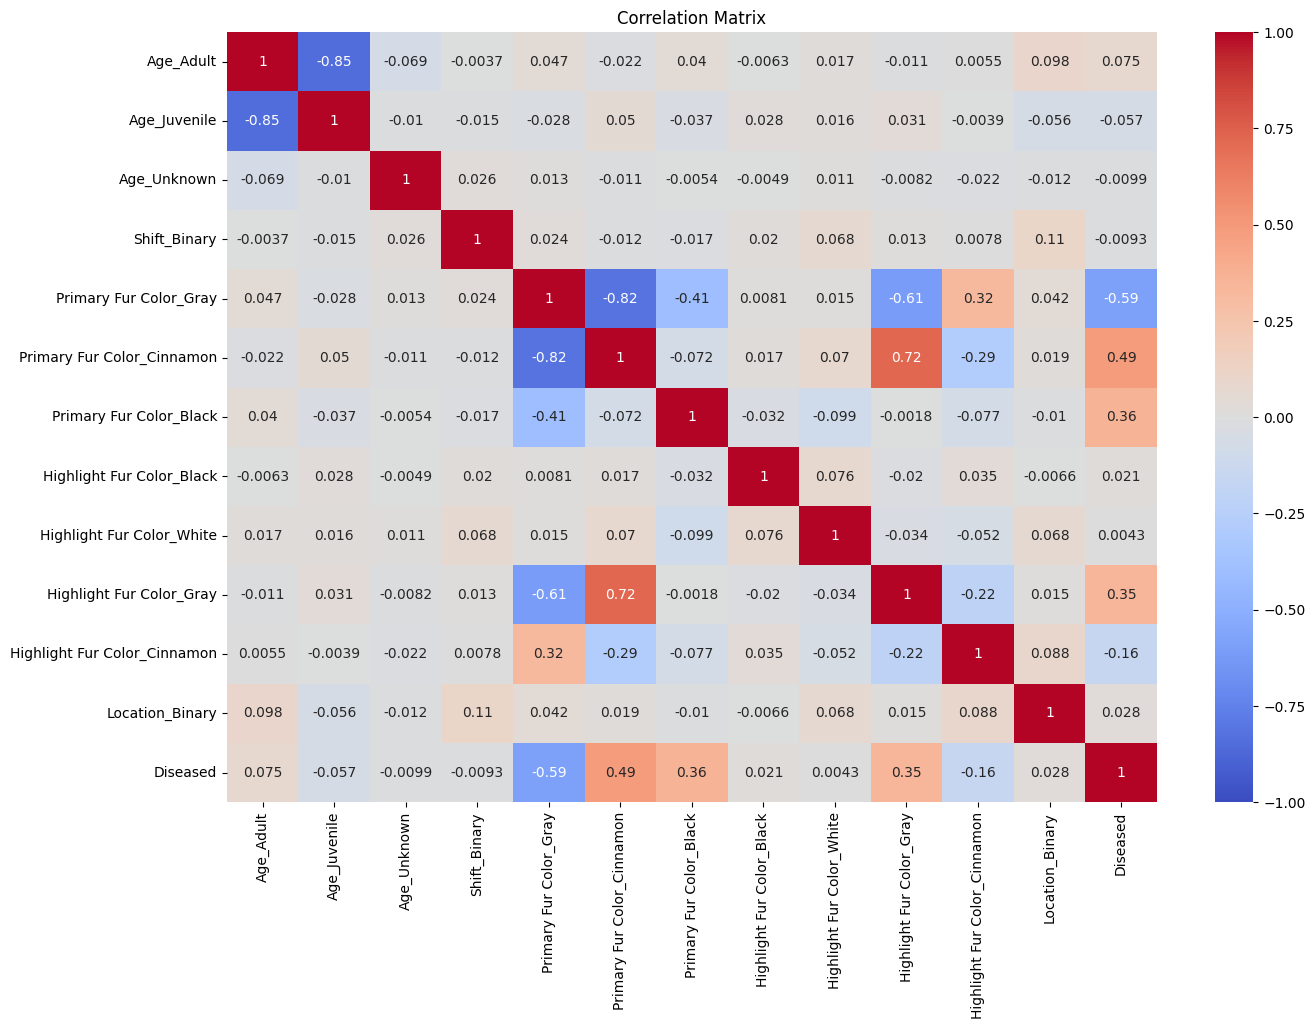

In [28]:
# heatmap of correlation matrix for Age_Adult	Age_Juvenile	Age_Unknown	Shift_Binary	Primary Fur Color_Gray	Primary Fur Color_Cinnamon	Primary Fur Color_Black	Highlight Fur Color_Black	Highlight Fur Color_White	Highlight Fur Color_Gray	Highlight Fur Color_Cinnamon	Location_Binary, Diseased

plt.figure(figsize=(15, 10))

sns.heatmap(train[['Age_Adult', 'Age_Juvenile', 'Age_Unknown', 'Shift_Binary', 'Primary Fur Color_Gray', 'Primary Fur Color_Cinnamon', 'Primary Fur Color_Black', 'Highlight Fur Color_Black', 'Highlight Fur Color_White', 'Highlight Fur Color_Gray', 'Highlight Fur Color_Cinnamon', 'Location_Binary', 'Diseased']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Matrix')
plt.show()


**Correlation Analysis of Squirrel Attributes with Disease Label:**

The heatmap provides insight into the relationship between various squirrel attributes (age, fur color, location) and the disease status.

Key observations:
- The correlation between **Primary Fur Color Cinnamon** and the **Diseased** label is moderately positive at **0.49**. This suggests a potential association between cinnamon-colored fur and a higher likelihood of being diseased.
- **Highlight Fur Color Cinnamon** also shows a moderate positive correlation with **Diseased** at **0.35**, indicating that squirrels with cinnamon highlight fur might also be more prone to disease.
- **Age attributes** (Adult, Juvenile, Unknown) generally have low correlations with the **Diseased** label, with **Age Juvenile** having the highest negative correlation at **-0.057**.
- **Primary Fur Color Gray** and **Highlight Fur Color White** show negative correlations with **Diseased** (-0.59 and -0.28, respectively). This suggests that squirrels with these fur colors may have a reduced likelihood of being diseased.

The correlations, while moderate in some cases, indicate that fur color—particularly cinnamon—might be a relevant feature for predicting disease status. Other attributes, such as age and certain fur colors, seem to have minimal impact on the disease.

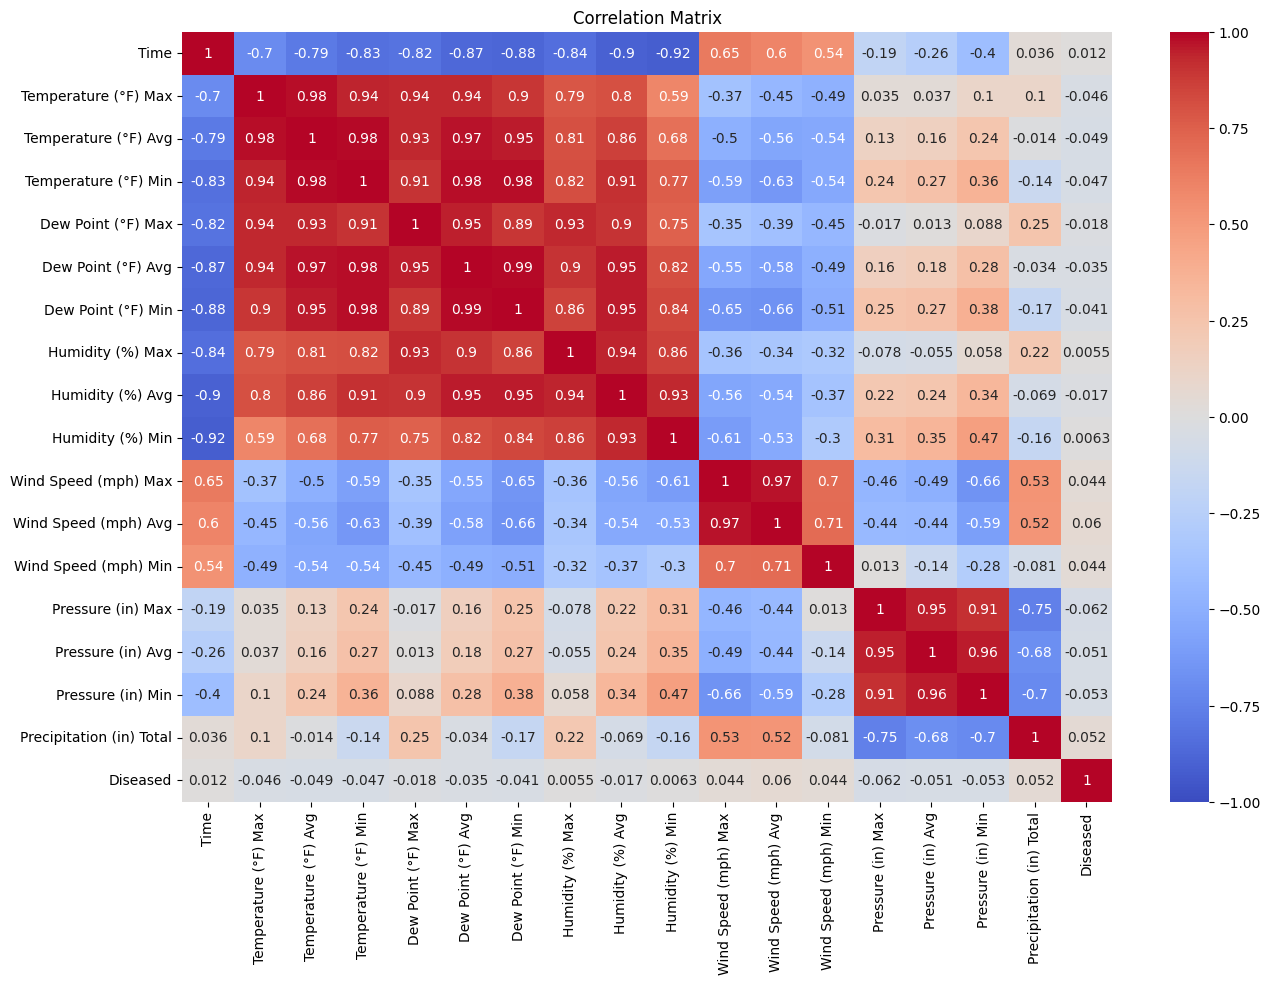

In [29]:
plt.figure(figsize=(15, 10))

sns.heatmap(train[['Time', 'Temperature (°F) Max', 'Temperature (°F) Avg', 'Temperature (°F) Min', 'Dew Point (°F) Max', 'Dew Point (°F) Avg', 'Dew Point (°F) Min', 'Humidity (%) Max', 'Humidity (%) Avg', 'Humidity (%) Min', 'Wind Speed (mph) Max', 'Wind Speed (mph) Avg', 'Wind Speed (mph) Min', 'Pressure (in) Max', 'Pressure (in) Avg', 'Pressure (in) Min', 'Precipitation (in) Total', 'Diseased']].corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlation Matrix')
plt.show()



## Correlation Analysis Summary:

The correlation heatmap reveals high redundancy among weather features, particularly between Temperature (°F) Max, Avg, and Min, as well as Dew Point, Humidity, Wind Speed, and Pressure. This suggests that many of these features can be reduced to simplify the model without losing significant predictive value.

Notably, there is a very low correlation between all weather features and the target label 'Diseased', indicating that these individual variables may not be strong predictors of disease status. The strongest correlation with 'Diseased' is just 0.052, implying that more complex interactions or feature engineering might be necessary to uncover significant patterns.

There are moderate negative correlations observed between Wind Speed and Pressure features, which might be worth exploring further for interaction effects.

In [30]:
# get the day from the date

train['Day'] = train['Date'].dt.day


In [31]:
# break up first half of month and second half of month

train['First_Half'] = train['Day'].apply(lambda x: 1 if x <= 15 else 0)

array([[<Axes: title={'center': 'X'}>, <Axes: title={'center': 'Y'}>,
        <Axes: title={'center': 'Date'}>,
        <Axes: title={'center': 'Hectare Squirrel Number'}>,
        <Axes: title={'center': 'Running'}>,
        <Axes: title={'center': 'Chasing'}>,
        <Axes: title={'center': 'Climbing'}>],
       [<Axes: title={'center': 'Eating'}>,
        <Axes: title={'center': 'Foraging'}>,
        <Axes: title={'center': 'Kuks'}>,
        <Axes: title={'center': 'Quaas'}>,
        <Axes: title={'center': 'Moans'}>,
        <Axes: title={'center': 'Tail flags'}>,
        <Axes: title={'center': 'Tail twitches'}>],
       [<Axes: title={'center': 'Approaches'}>,
        <Axes: title={'center': 'Indifferent'}>,
        <Axes: title={'center': 'Runs from'}>,
        <Axes: title={'center': 'Time'}>,
        <Axes: title={'center': 'Temperature (°F) Max'}>,
        <Axes: title={'center': 'Temperature (°F) Avg'}>,
        <Axes: title={'center': 'Temperature (°F) Min'}>],
       [<Ax

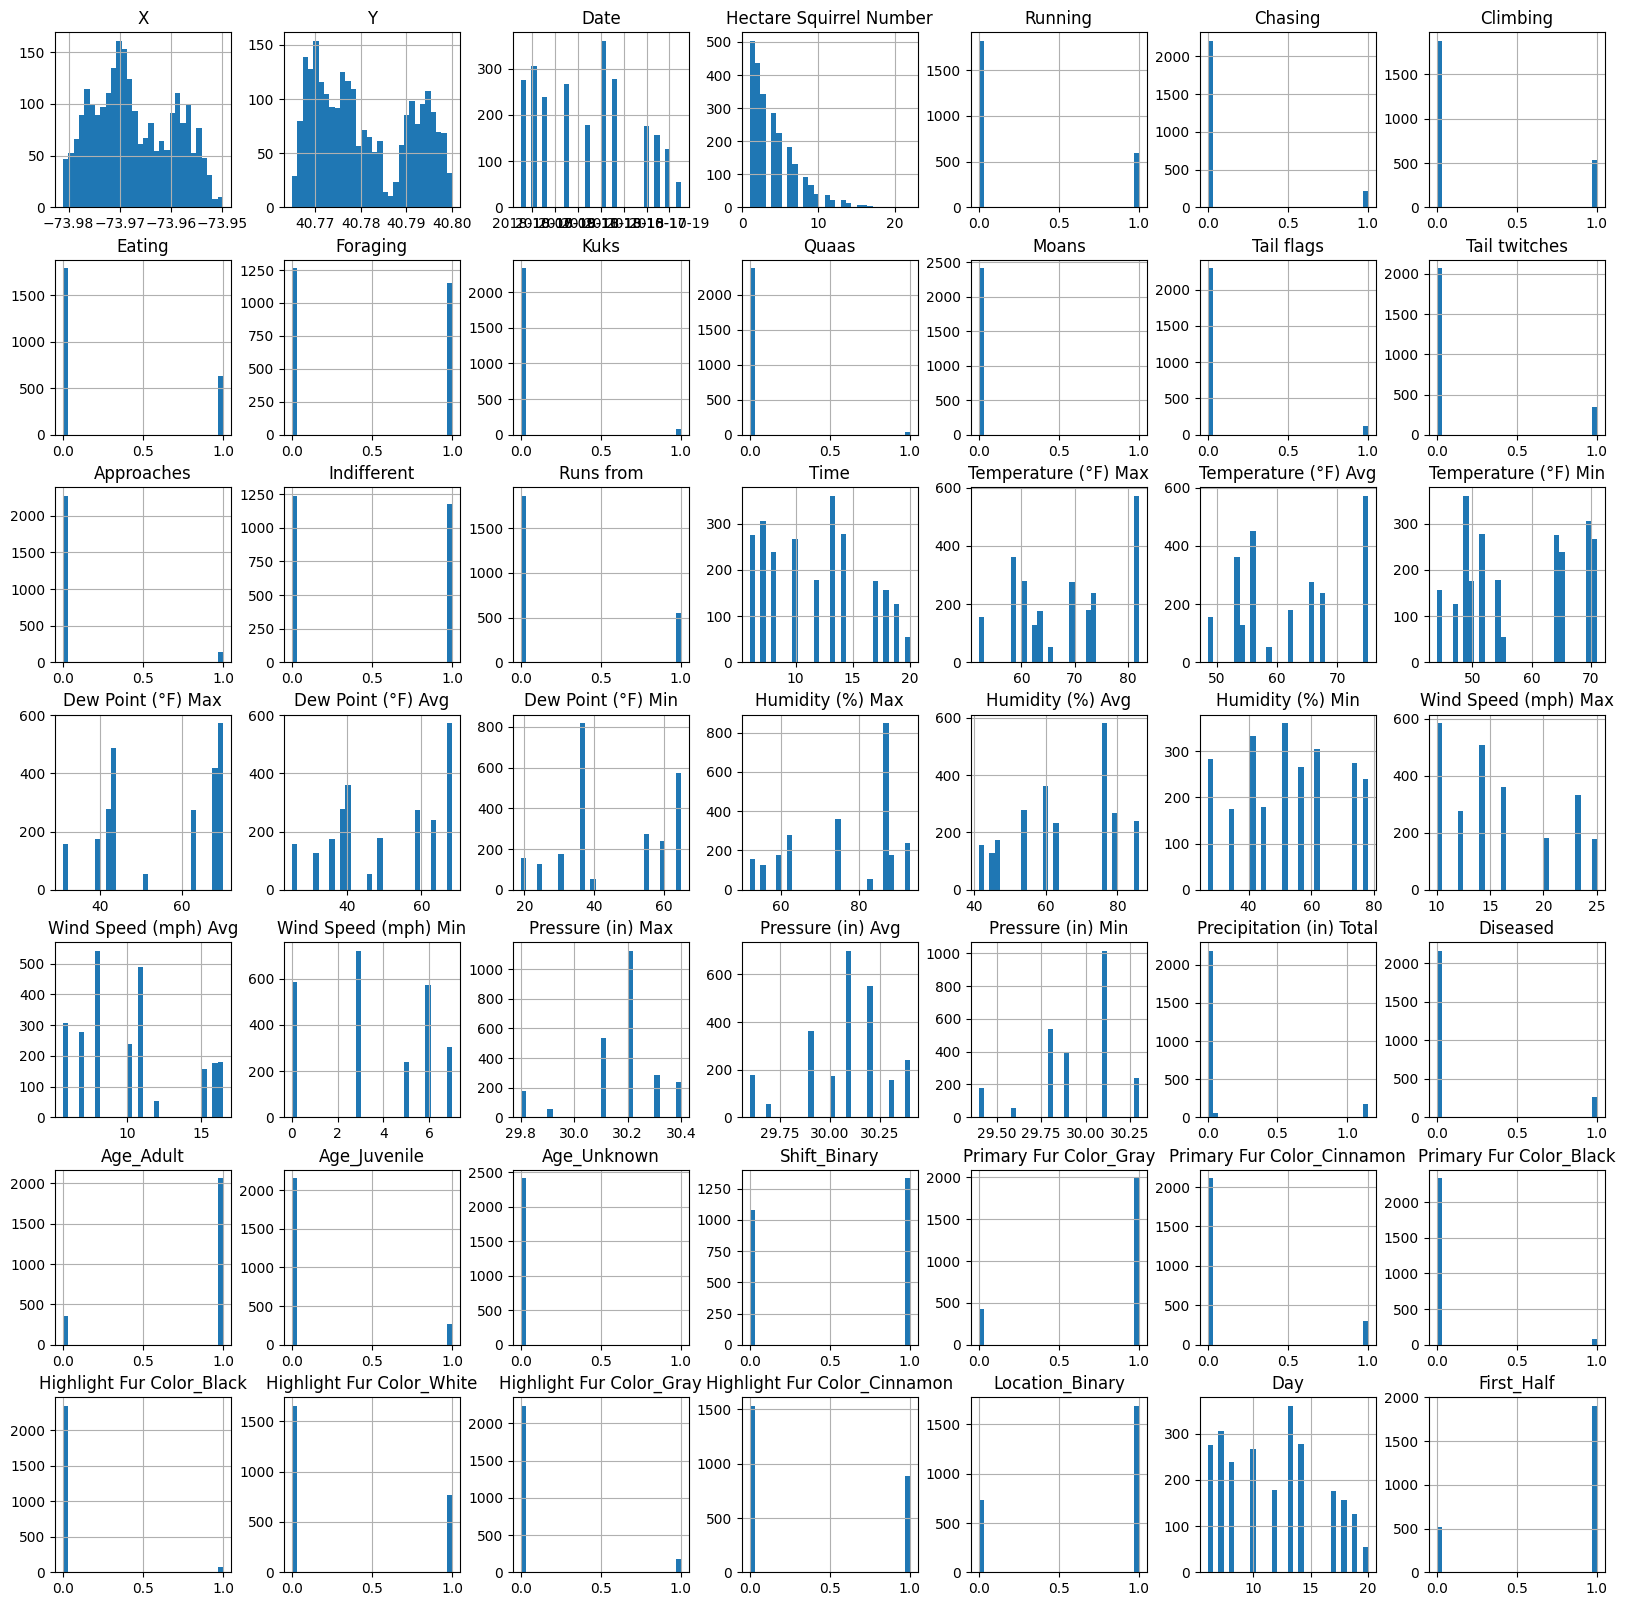

In [32]:
#histogram of train

train.hist(figsize=(20, 20), bins=30)

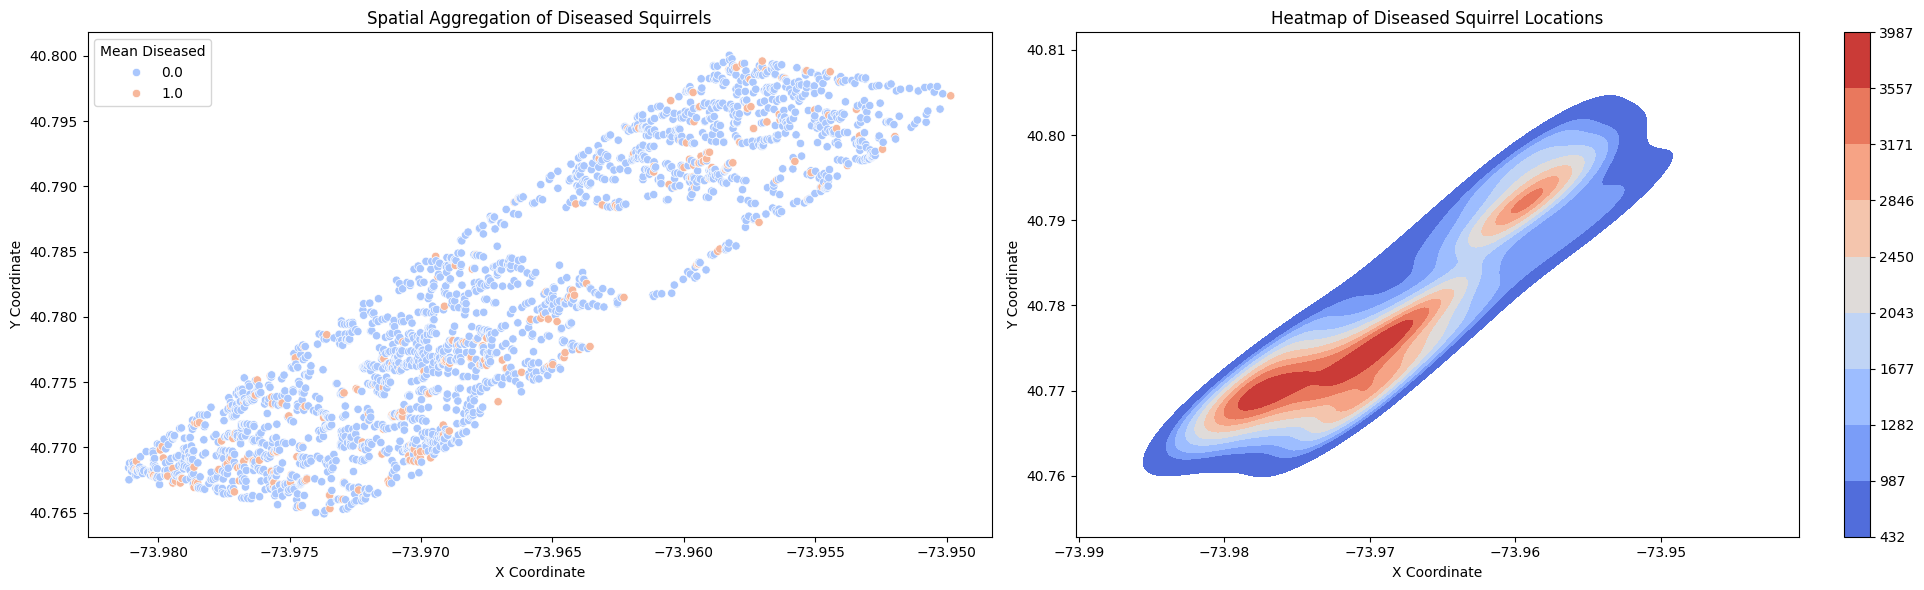

In [33]:
# Group by spatial coordinates and calculate the mean of the target label
spatial_aggregation = train.groupby(['X', 'Y'])['Diseased'].mean().reset_index()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot the spatial aggregation to visualize the correlation
sns.scatterplot(data=spatial_aggregation, x='X', y='Y', hue='Diseased', palette='coolwarm', legend='full', ax=axes[0])
axes[0].set_title('Spatial Aggregation of Diseased Squirrels')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')
axes[0].legend(title='Mean Diseased')

# Filter the data to include only diseased squirrels
diseased_squirrels = train[train['Diseased'] == 1]

# Create a heatmap of the locations of diseased squirrels
sns.kdeplot(data=diseased_squirrels, x='X', y='Y', fill=True, cmap='coolwarm', cbar=True, ax=axes[1])
axes[1].set_title('Heatmap of Diseased Squirrel Locations')
axes[1].set_xlabel('X Coordinate')
axes[1].set_ylabel('Y Coordinate')

plt.tight_layout()
plt.show()

# Spatial Analysis of Diseased Squirrels

This visualization consists of two plots that aim to explore the spatial distribution of diseased squirrels in the dataset and identify any potential spatial patterns.

## Left Plot: Spatial Aggregation of Diseased Squirrels
- **Description**: This scatter plot represents squirrel sightings, with each point corresponding to a sighting's coordinates (`X`, `Y`).
- **Color Code**: Squirrels are color-coded based on the `Diseased` label:
  - **0 (Blue)**: Represents healthy squirrels.
  - **1 (Orange)**: Represents diseased squirrels.
- **Purpose**: By aggregating the sightings based on the `Diseased` status, this plot helps in identifying any clusters or high-density areas where diseased squirrels are prevalent.

## Right Plot: Heatmap of Diseased Squirrel Locations
- **Description**: This heatmap focuses specifically on the locations of diseased squirrels.
- **Color Gradient**: Indicates the density of diseased squirrel sightings:
  - **Red areas**: High density of diseased squirrel sightings.
  - **Blue areas**: Low density of diseased squirrel sightings.
- **Purpose**: The heatmap provides a smoother view of spatial density, helping to visually highlight areas with a higher prevalence of diseased squirrels.

## Insights
- The comparison between the scatter plot and heatmap allows for a deeper understanding of the spatial distribution of diseased squirrels.
- The density-based color gradient in the heatmap may help identify hotspot areas with a higher concentration of diseased sightings, which could be useful for further analysis, clustering, or targeted disease management.

In [34]:
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
import numpy as np

# Extract the coordinates of diseased squirrels
diseased_coords = train[train['Diseased'] == 1][['X', 'Y']].values

# Use DBSCAN to identify clusters of diseased squirrels
dbscan = DBSCAN(eps=0.0002, min_samples=2)
diseased_clusters = dbscan.fit_predict(diseased_coords)

# Get the coordinates of the cluster centers
cluster_centers = []
for cluster in set(diseased_clusters):
    if cluster != -1:  # Ignore noise points
        cluster_points = diseased_coords[diseased_clusters == cluster]
        cluster_center = cluster_points.mean(axis=0)
        cluster_centers.append(cluster_center)

cluster_centers = np.array(cluster_centers)

# Calculate the distance from each squirrel to the nearest diseased squirrel cluster
nbrs = NearestNeighbors(n_neighbors=1).fit(cluster_centers)
distances, _ = nbrs.kneighbors(train[['X', 'Y']].values)

# Create the 'hotspots' feature based on the distances
train['hotspots'] = distances

### `hotspots` Feature Documentation

The `hotspots` feature represents the **distance from each squirrel to the nearest center of a cluster of diseased squirrels**. Here’s a breakdown of how this feature is generated and what it measures:

1. **Clustering Diseased Squirrels**:
   - Using DBSCAN (Density-Based Spatial Clustering of Applications with Noise), clusters of diseased squirrels are identified based on their `X` and `Y` coordinates.
   - DBSCAN parameters (`eps=0.001` and `min_samples=2`) specify that squirrels within a close range form a cluster if there are at least two squirrels in proximity. Any points that don’t meet these parameters are labeled as noise and ignored in cluster center calculations.

2. **Calculating Cluster Centers**:
   - For each diseased cluster identified by DBSCAN, the mean of the `X` and `Y` coordinates of squirrels within the cluster is calculated. This mean point serves as the **center of the diseased cluster**, representing the geographical center of the area with a high concentration of diseased squirrels.

3. **Determining Distance to Nearest Cluster Center**:
   - Using the `NearestNeighbors` algorithm, the distance from each squirrel (in the entire dataset) to the closest diseased cluster center is computed.
   - These distance values are stored in the `hotspots` feature, capturing each squirrel’s proximity to the nearest center of a diseased cluster.

### Interpretation of `hotspots`
- **Small `hotspots` Value**: Indicates that a squirrel is close to the center of a diseased cluster, suggesting a higher potential for exposure to diseased squirrels.
- **Large `hotspots` Value**: Indicates that a squirrel is far from any diseased clusters, suggesting a lower likelihood of exposure.

In summary, the `hotspots` feature quantifies each squirrel’s proximity to high-density areas of diseased squirrels, making it a possible risk indicator for disease exposure based on spatial closeness.


      hotspots_distance  hotspots_inverse  hotspots_log
1403           0.000405       2471.848997     -7.812722
2648           0.001616        618.722925     -6.427658
1374           0.002400        416.609052     -6.032148
548            0.000124       8093.754724     -8.998848
1897           0.000197       5084.556582     -8.533963


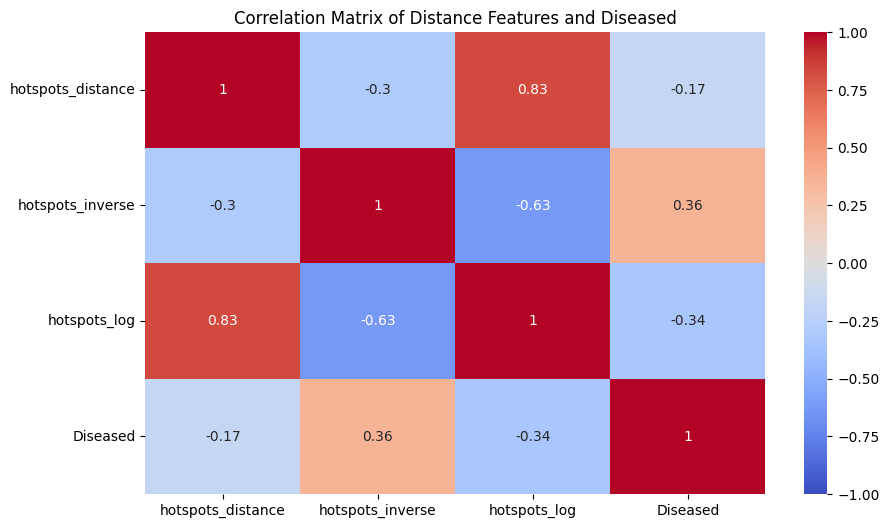

In [35]:
# Add the actual hotspots distance as a continuous feature
train['hotspots_distance'] = train['hotspots']

# Apply transformations
train['hotspots_inverse'] = 1 / train['hotspots']
train['hotspots_log'] = np.log(train['hotspots'])

# Display the first few rows to verify the new features
print(train[['hotspots_distance', 'hotspots_inverse', 'hotspots_log']].head())

# Calculate the correlation between the new features and 'Diseased'
distance_features = ['hotspots_distance', 'hotspots_inverse', 'hotspots_log']
correlation_distance_diseased = train[distance_features + ['Diseased']].corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_distance_diseased, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Distance Features and Diseased")
plt.show()

### Analysis Based on Correlation with the `Diseased` Feature:

1. **Hotspots Inverse**:
   - The feature `hotspots_inverse` shows a moderate positive correlation (**0.36**) with the `Diseased` variable.
   - This indicates that as the inverse of hotspots increases (likely meaning closer proximity to hotspots), the likelihood of disease presence also increases.
   - This makes `hotspots_inverse` a potentially useful predictor for identifying diseased squirrels.

2. **Hotspots Log**:
   - `hotspots_log` has a moderate negative correlation (**-0.34**) with `Diseased`.
   - This suggests that higher logarithmic values of hotspots (potentially indicating larger distances) are associated with a lower probability of squirrels being diseased.

3. **Hotspots Distance**:
   - The correlation between `hotspots_distance` and `Diseased` is weakly negative (**-0.17**).
   - This weak relationship implies that the raw distance alone may not be strongly indicative of disease presence but could still provide slight explanatory value.

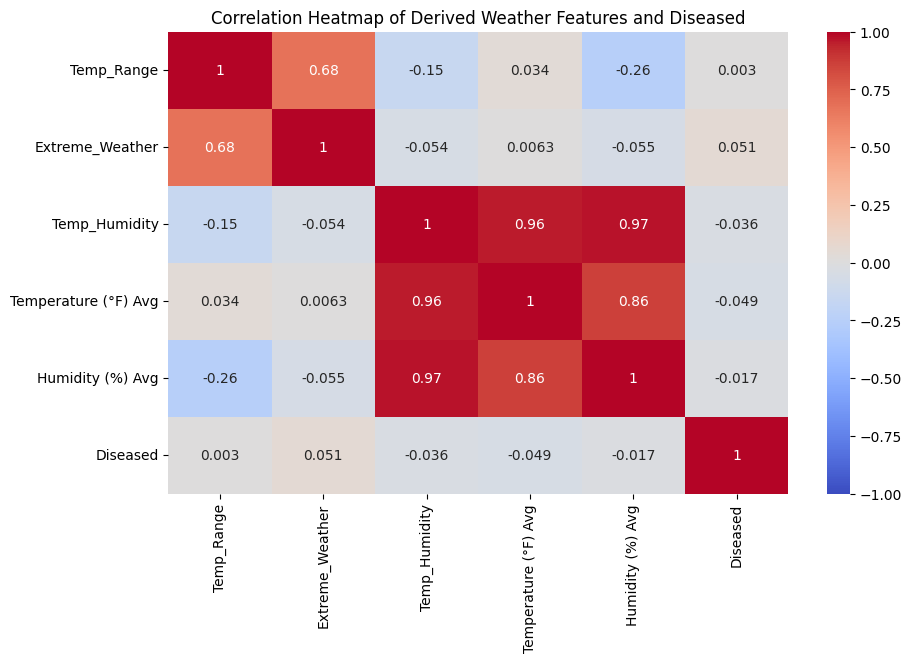

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Derived features
train['Temp_Range'] = train['Temperature (°F) Max'] - train['Temperature (°F) Min']
train['Extreme_Weather'] = ((train['Temperature (°F) Max'] > 85) | (train['Temperature (°F) Min'] < 30) | (train['Precipitation (in) Total'] > 1)).astype(int)
train['Temp_Humidity'] = train['Temperature (°F) Avg'] * train['Humidity (%) Avg']
train['Temp_Category'] = pd.cut(train['Temperature (°F) Avg'], bins=[-float('inf'), 50, 70, 90, float('inf')], labels=['Cold', 'Moderate', 'Warm', 'Hot'])

# Calculate correlations with the target label
weather_features = ['Temp_Range', 'Extreme_Weather', 'Temp_Humidity', 'Temperature (°F) Avg', 'Humidity (%) Avg']
correlations = train[weather_features + ['Diseased']].corr()

# Plot the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(correlations, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap of Derived Weather Features and Diseased")
plt.show()


### Analysis of Correlation with `Diseased` using `Weather`:

1. **Temp_Range**: Negligible correlation (**0.003**); not significant for predicting disease.  
2. **Extreme_Weather**: Weak positive correlation (**0.051**); slight potential for disease prediction.  
3. **Temp_Humidity**: Weak negative correlation (**-0.036**); minimal relevance.  
4. **Temperature (°F) Avg**: Negligible negative correlation (**-0.049**); not impactful.  
5. **Humidity (%) Avg**: Negligible negative correlation (**-0.017**); no significant relationship.

### Key Insight:
None of the features show strong correlation with disease. `Extreme_Weather` has the highest, albeit weak, correlation and could be explored further.

           X          Y Hectare Shift       Date  Hectare Squirrel Number  \
0 -73.970067  40.774286     12F    PM 2018-10-07                        8   
1 -73.970643  40.776293     13E    AM 2018-10-17                        7   
2 -73.956474  40.793885     36F    AM 2018-10-17                        3   
3 -73.964383  40.781545     21F    PM 2018-10-18                        3   
4 -73.971074  40.772327     10F    PM 2018-10-19                        7   

     Age Primary Fur Color Highlight Fur Color  \
0  Adult              Gray            Cinnamon   
1  Adult              Gray            Cinnamon   
2  Adult              Gray            Cinnamon   
3  Adult              Gray            Cinnamon   
4  Adult              Gray            Cinnamon   

  Combination of Primary and Highlight Color  ... Humidity_Max_Rolling  \
0                              Gray+Cinnamon  ...            84.000000   
1                              Gray+Cinnamon  ...            74.000000   
2             

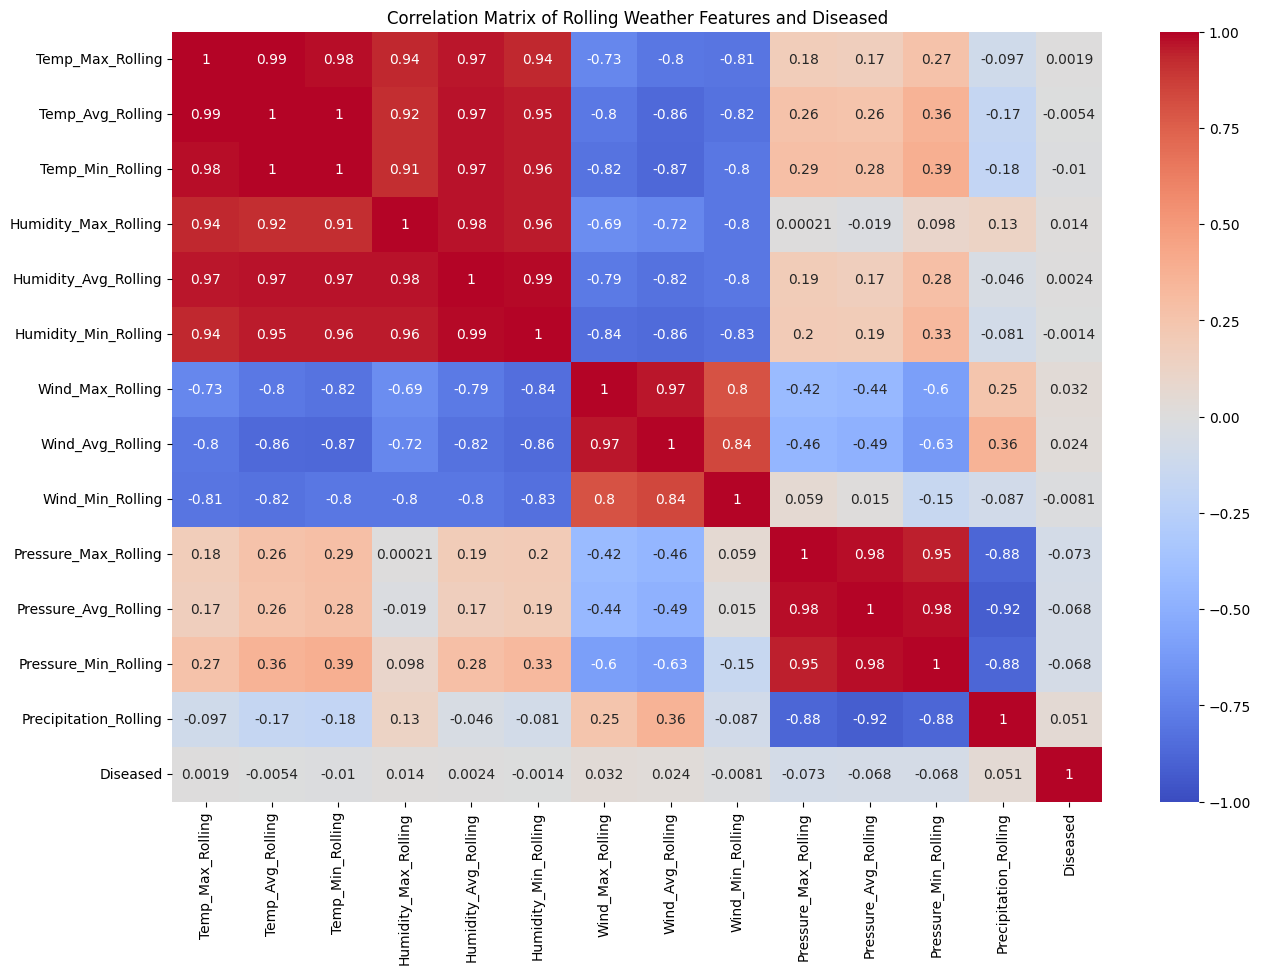

In [37]:
# Define the window size for rolling averages
window_size = 3

# Create rolling average features for weather data
weather['Temp_Max_Rolling'] = weather['Temperature (°F) Max'].rolling(window=window_size).mean()
weather['Temp_Avg_Rolling'] = weather['Temperature (°F) Avg'].rolling(window=window_size).mean()
weather['Temp_Min_Rolling'] = weather['Temperature (°F) Min'].rolling(window=window_size).mean()
weather['Humidity_Max_Rolling'] = weather['Humidity (%) Max'].rolling(window=window_size).mean()
weather['Humidity_Avg_Rolling'] = weather['Humidity (%) Avg'].rolling(window=window_size).mean()
weather['Humidity_Min_Rolling'] = weather['Humidity (%) Min'].rolling(window=window_size).mean()
weather['Wind_Max_Rolling'] = weather['Wind Speed (mph) Max'].rolling(window=window_size).mean()
weather['Wind_Avg_Rolling'] = weather['Wind Speed (mph) Avg'].rolling(window=window_size).mean()
weather['Wind_Min_Rolling'] = weather['Wind Speed (mph) Min'].rolling(window=window_size).mean()
weather['Pressure_Max_Rolling'] = weather['Pressure (in) Max'].rolling(window=window_size).mean()
weather['Pressure_Avg_Rolling'] = weather['Pressure (in) Avg'].rolling(window=window_size).mean()
weather['Pressure_Min_Rolling'] = weather['Pressure (in) Min'].rolling(window=window_size).mean()
weather['Precipitation_Rolling'] = weather['Precipitation (in) Total'].rolling(window=window_size).mean()

# Merge the rolling weather data with the squirrel data
train = pd.merge(train, weather[['Date', 'Temp_Max_Rolling', 'Temp_Avg_Rolling', 'Temp_Min_Rolling', 'Humidity_Max_Rolling', 'Humidity_Avg_Rolling', 'Humidity_Min_Rolling', 'Wind_Max_Rolling', 'Wind_Avg_Rolling', 'Wind_Min_Rolling', 'Pressure_Max_Rolling', 'Pressure_Avg_Rolling', 'Pressure_Min_Rolling', 'Precipitation_Rolling']], on='Date', how='left')

# Display the first few rows of the updated dataframe
print(train.head())

# Calculate the correlation between the new rolling weather features and the 'Diseased' target
correlation_rolling_weather = train[['Temp_Max_Rolling', 'Temp_Avg_Rolling', 'Temp_Min_Rolling', 'Humidity_Max_Rolling', 'Humidity_Avg_Rolling', 'Humidity_Min_Rolling', 'Wind_Max_Rolling', 'Wind_Avg_Rolling', 'Wind_Min_Rolling', 'Pressure_Max_Rolling', 'Pressure_Avg_Rolling', 'Pressure_Min_Rolling', 'Precipitation_Rolling', 'Diseased']].corr()

# Plot the correlation matrix
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_rolling_weather, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Matrix of Rolling Weather Features and Diseased")
plt.show()

## Rolling Weather Data
Rolling data creates a windowed average (or another statistic) over time, which can better represent how sustained weather conditions, rather than isolated daily fluctuations, influence the likelihood of squirrel diseases.

**Key Summary** 

After experimenting with the weather using several different methods, there really was little to no correlation whatsoever. This might just mean that the weather data is overall, not useful for this type of problem, and or more data is needed to make a correlation. 

# Key Points for Visualization

- Any Color feature is pretty important
- Weather is basically useless
- Used unsupervised learning (DBSCAN) to find clusters of diseased squirrels (found good correaltion of -0.17 at regular hotspot and inverse hotspot of 0.36)

### More in depth analysis within the section above

In [38]:
numerical_features = ['Temperature (°F) Max', 'Temperature (°F) Avg', 'Temperature (°F) Min', 'Dew Point (°F) Max', 'Dew Point (°F) Avg', 'Dew Point (°F) Min', 'Humidity (%) Max', 
                      'Humidity (%) Avg', 'Humidity (%) Min', 'Wind Speed (mph) Max', 'Wind Speed (mph) Avg', 'Wind Speed (mph) Min', 'Pressure (in) Max', 'Pressure (in) Avg', 
                      'Pressure (in) Min', 'Precipitation (in) Total', 'X', 'Y']

categorical_features = ['Primary Fur Color', 'Shift', 'Highlight Fur Color', 'Location', 'Age']

Droppable_Features = ['Date', 'Unique Squirrel ID', 'Hectare', 'Hectare Squirrel Number', 'Combination of Primary and Highlight Color', 'Color notes',
                       'Above Ground Sighter Measurement', 'Specific Location', 'Other Activities', 'Other Interactions', 'Lat/Long', 'Time']

behavior_columns = ['Running', 'Chasing', 'Climbing', 'Eating', 'Foraging', 'Kuks', 'Quaas', 'Moans', 'Tail flags', 'Tail twitches', 'Approaches', 'Indifferent', 'Runs from']

In [39]:
print(X_train.columns.tolist())  # Print all column names as a list


['X', 'Y', 'Unique Squirrel ID', 'Hectare', 'Shift', 'Date', 'Hectare Squirrel Number', 'Age', 'Primary Fur Color', 'Highlight Fur Color', 'Combination of Primary and Highlight Color', 'Color notes', 'Location', 'Above Ground Sighter Measurement', 'Specific Location', 'Running', 'Chasing', 'Climbing', 'Eating', 'Foraging', 'Other Activities', 'Kuks', 'Quaas', 'Moans', 'Tail flags', 'Tail twitches', 'Approaches', 'Indifferent', 'Runs from', 'Other Interactions', 'Lat/Long', 'Time', 'Temperature (°F) Max', 'Temperature (°F) Avg', 'Temperature (°F) Min', 'Dew Point (°F) Max', 'Dew Point (°F) Avg', 'Dew Point (°F) Min', 'Humidity (%) Max', 'Humidity (%) Avg', 'Humidity (%) Min', 'Wind Speed (mph) Max', 'Wind Speed (mph) Avg', 'Wind Speed (mph) Min', 'Pressure (in) Max', 'Pressure (in) Avg', 'Pressure (in) Min', 'Precipitation (in) Total']


In [40]:
print('Primary Fur Color' in X_train.columns)
print('Highlight Fur Color' in X_train.columns)


True
True


In [41]:
train['Location'].value_counts()

Location
Ground Plane    1690
Above Ground     679
Name: count, dtype: int64

In [42]:
# Define the numerical transformer as a pipeline
NumericalTransformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('hotspots transformer', HotspotsTransformer()),
        ('scaler', StandardScaler())
        ]
)



categorical_transformer = ColumnTransformer(
    transformers=[
        # Encode categorical features
        ('encoder', OneHotEncoder(handle_unknown='ignore'), ['Primary Fur Color', 'Highlight Fur Color', 'Age', 'Location']),
        # Create a binary feature for 'Shift' column
        ('Shift_transformer', SingleColumnBinaryTransformer(column='Shift', positive_value='AM'), ['Shift'])
    ]
)
# Define the full preprocessor
preprocessor = Pipeline(steps=[
    ('pre', ColumnTransformer(
        transformers=[
            ('drop', DropColumnsTransformer(columns=Droppable_Features), Droppable_Features),  
            ('binary_behavior', BinaryBehaviorTransformer(behavior_columns=behavior_columns), behavior_columns),
            ('num', NumericalTransformer, numerical_features),
            ('cat', categorical_transformer, categorical_features)
        ], remainder='passthrough',
        verbose_feature_names_out=False
    )),
     ('feature_selection', SelectFromModel(RandomForestClassifier(random_state=42)))
])


preprocessor

Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('drop',
                                                  DropColumnsTransformer(columns=['Date',
                                                                                  'Unique '
                                                                                  'Squirrel '
                                                                                  'ID',
                                                                                  'Hectare',
                                                                                  'Hectare '
                                                                                  'Squirrel '
                                                                                  'Number',
                                                                                  'Combination '
                                                                                  'of '
                                                                                  'Primary '
                                                                                  'and '
                                                                                  'Highlight '
                                                                                  'Color',
                                                                                  'Color '
                                                                                  'notes',
                                                                                  'Above '
                                                                                  'Ground '
                                                                                  'Sighter '
                                                                                  'Measurement',
                                                                                  'Specific '
                                                                                  'Location',
                                                                                  'Other '
                                                                                  'Activities',
                                                                                  'Other '
                                                                                  'Interaction...
                                                                                   ['Primary '
                                                                                    'Fur '
                                                                                    'Color',
                                                                                    'Highlight '
                                                                                    'Fur '
                                                                                    'Color',
                                                                                    'Age',
                                                                                    'Location']),
                                                                                  ('Shift_transformer',
                                                                                   SingleColumnBinaryTransformer(column='Shift',
                                                                                                                 positive_value='AM'),
                                                                                   ['Shift'])]),
                                                  ['Primary Fur Color', 'Shift',
                                                   'Highlight Fur Color',
                                                   'Location', 'Age'])],
        

In [43]:
X = preprocessor.fit_transform(X_train, y_train)

X_transformed_df = pd.DataFrame(X)

X_transformed_df.tail()

,0,1,2,3,4,5
2413,-0.844971,0.0,0.0,1.0,0.0,0.0
2414,0.121738,0.0,0.0,1.0,0.0,1.0
2415,0.121738,0.0,0.0,1.0,0.0,0.0
2416,-1.811681,0.0,0.0,1.0,0.0,1.0
2417,1.088448,0.0,0.0,1.0,0.0,1.0


# Data Pipeline Documentation

## Overview
This document outlines the steps and transformations implemented in the data pipeline for preprocessing both numerical and categorical features. The pipeline ensures data is clean, consistent, and optimized for use in machine learning models.


## Numerical Data Transformer

### Steps:
1. **Imputation with Median**  
   - Missing values are filled using the median value.  
   - Reason: The data is not normally distributed, making median imputation more robust than mean imputation.

2. **Custom Hotspots Transformation**  
   - A custom transformer calculates inverse hotspots using `X` and `Y` coordinates.  
   - Reason: Adds a meaningful feature derived from the positional data.

3. **Standard Scaling**  
   - Scales numerical features using a standard scaler (mean = 0, standard deviation = 1).  
   - Reason: Ensures features are on the same scale since there are no significant outliers in the data.


## Categorical Data Transformer

### Steps:
1. **One-Hot Encoding (OHE)**  
   - Applied to features like `primary_color`, `highlighter_color`, `age`, and `location`.  
   - Reason: These features are non-binary and may contain missing values. For example, an unknown `location` could indicate an unnatural environment, such as a sick individual's movement. OHE ensures missing values are represented explicitly.

2. **Binary Transformation**  
   - Applied to `shift` (day or night).  
   - Reason: The feature is binary and contains no missing values, making a binary transformation more efficient for modeling.


## Preprocessing Steps

1. **Drop Unnecessary Features**  
   - Features like dates and other irrelevant columns are removed to reduce noise in the model.

2. **Binary Behavior Transformation**  
   - All boolean features are converted to binary format.  
   - Reason: Ensures consistency and removes ambiguity, as these features have no missing values.

3. **Integration of Numerical and Categorical Transformers**  
   - Combines both numerical and categorical preprocessing into a unified pipeline.

4. **Feature Selection with Random Classifier**  
   - Uses a random classifier to identify and retain only the most useful features.  
   - Reason: Simplifies the pipeline while maintaining predictive performance.


## Summary
The data pipeline handles missing values, scales numerical features, and encodes categorical variables effectively. It ensures that the data is clean, interpretable, and ready for training a machine learning model. By focusing on feature selection and transformation, the pipeline minimizes complexity while maximizing model accuracy.


# Random Forests

In [44]:
# Create the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42)

# Perform cross-validation predictions
y_train_pred_cv_rf = cross_val_predict(rf_clf, X, y_train, cv=5)

# Calculate cross-validated scores
precision_cv_rf = precision_score(y_train, y_train_pred_cv_rf)
recall_cv_rf = recall_score(y_train, y_train_pred_cv_rf)
f1_cv_rf = f1_score(y_train, y_train_pred_cv_rf)

print(f"Cross-Validated Precision: {precision_cv_rf:.4f}")
print(f"Cross-Validated Recall: {recall_cv_rf:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_rf:.4f}")

Cross-Validated Precision: 0.6223
Cross-Validated Recall: 0.5620
Cross-Validated F1 Score: 0.5906


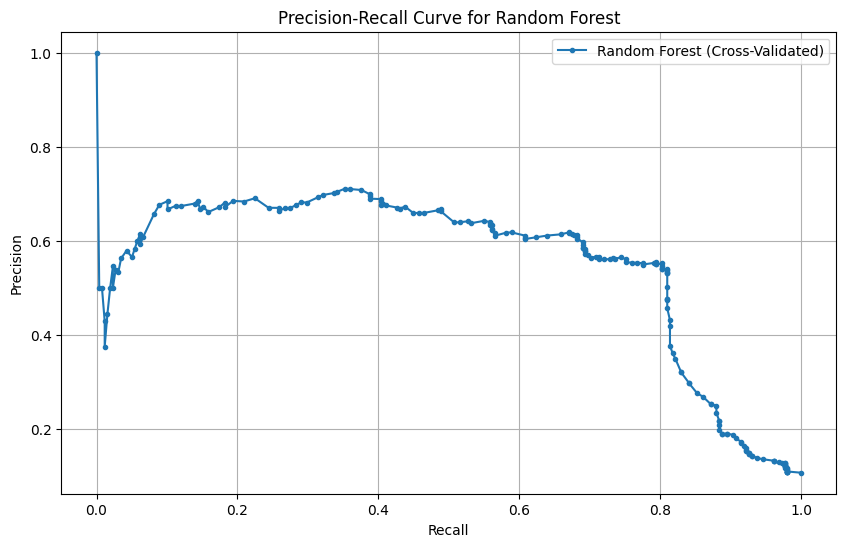

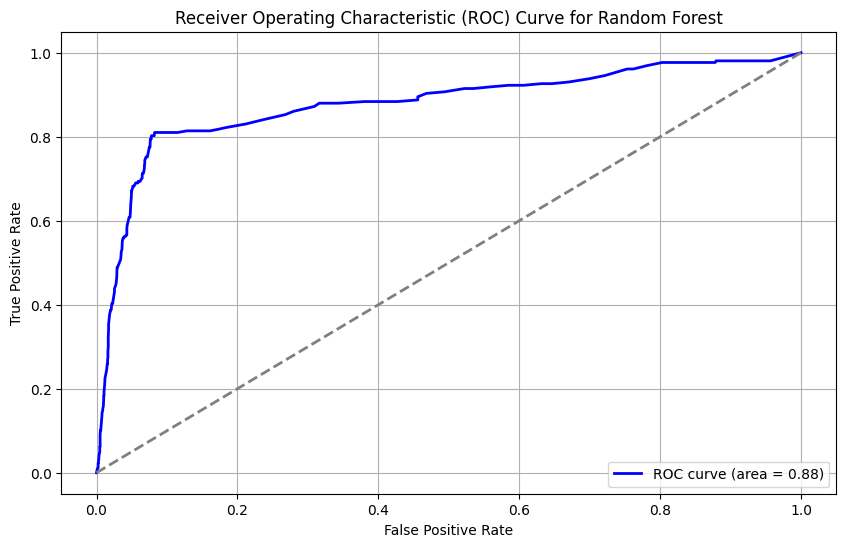

In [45]:
# Get the decision scores for the cross-validated predictions
y_scores_rf_cv = cross_val_predict(rf_clf, X, y_train, cv=5, method='predict_proba')[:, 1]

# Calculate precision and recall values
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_train, y_scores_rf_cv)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_rf, precision_rf, marker='.', label='Random Forest (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Random Forest')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_rf, tpr_rf, roc_thresholds_rf = roc_curve(y_train, y_scores_rf_cv)

# Calculate the AUC (Area Under the Curve)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_rf:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Random Forest')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [46]:
# create random forest off of the best estimator

# Create the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42, n_estimators=10, min_samples_split=35, min_samples_leaf=1, max_features='log2', max_depth=45, class_weight='balanced', bootstrap=True)

# Perform cross-validation predictions to get predicted probabilities
y_train_pred_proba_rf = cross_val_predict(rf_clf, X, y_train, cv=5, method='predict_proba')

# Select the probabilities for the positive class (index 1)
y_train_pred_proba_rf_pos_class = y_train_pred_proba_rf[:, 1]

# Set a higher threshold, e.g., 0.7
threshold = .73
y_train_pred_cv_rf = (y_train_pred_proba_rf_pos_class >= threshold).astype(int)

# Calculate cross-validated scores
precision_cv_rf = precision_score(y_train, y_train_pred_cv_rf)
recall_cv_rf = recall_score(y_train, y_train_pred_cv_rf)
f1_cv_rf = f1_score(y_train, y_train_pred_cv_rf)

print(f"Cross-Validated Precision: {precision_cv_rf:.4f}")
print(f"Cross-Validated Recall: {recall_cv_rf:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_rf:.4f}")

Cross-Validated Precision: 0.5580
Cross-Validated Recall: 0.7829
Cross-Validated F1 Score: 0.6516


# Gradient Boosting

In [47]:
# Create the GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(random_state=42)

# Perform cross-validation predictions
y_train_pred_cv_gb = cross_val_predict(gb_clf, X, y_train, cv=5)

# Calculate cross-validated scores
precision_cv_gb = precision_score(y_train, y_train_pred_cv_gb)
recall_cv_gb = recall_score(y_train, y_train_pred_cv_gb)
f1_cv_gb = f1_score(y_train, y_train_pred_cv_gb)

print(f"Cross-Validated Precision: {precision_cv_gb:.4f}")
print(f"Cross-Validated Recall: {recall_cv_gb:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_gb:.4f}")

Cross-Validated Precision: 0.6080
Cross-Validated Recall: 0.5891
Cross-Validated F1 Score: 0.5984


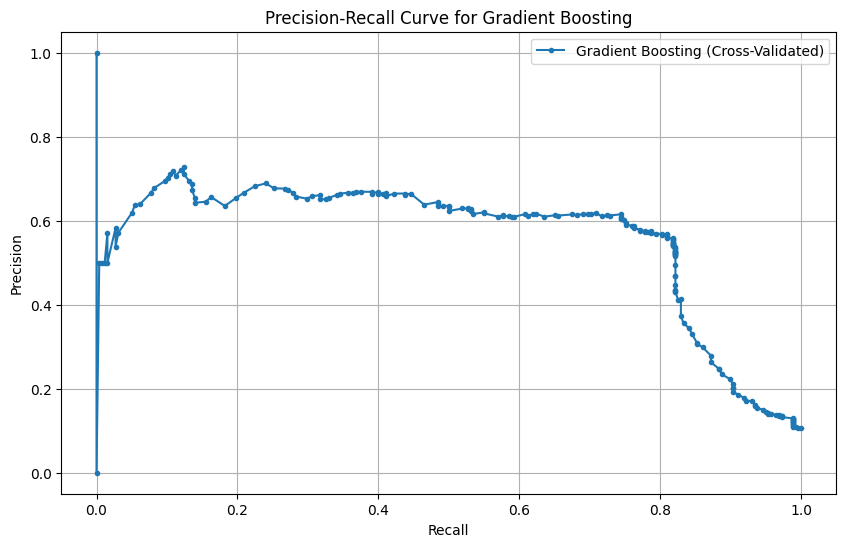

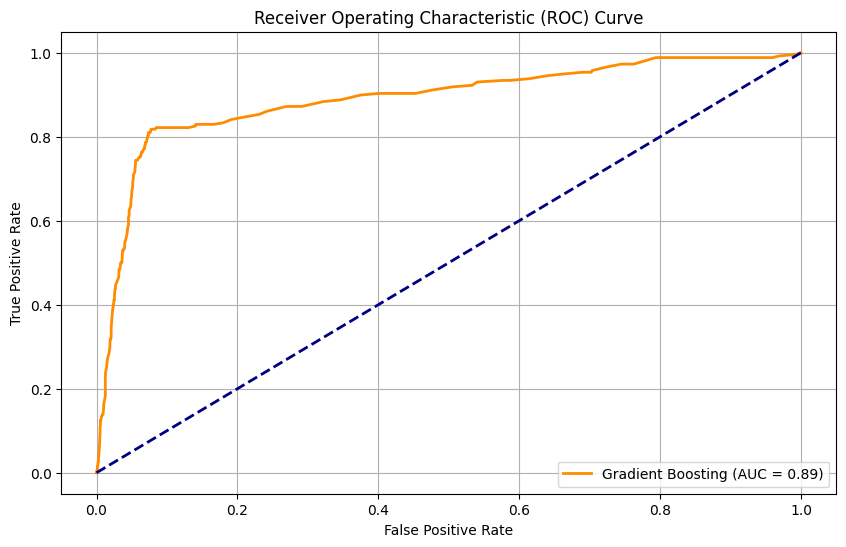

In [48]:
# Get the decision scores for the cross-validated predictions
y_scores_gb_cv = cross_val_predict(gb_clf, X, y_train, cv=5, method='predict_proba')[:, 1]

# Calculate precision and recall values
precision_gb, recall_gb, thresholds_gb = precision_recall_curve(y_train, y_scores_gb_cv)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_gb, precision_gb, marker='.', label='Gradient Boosting (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Gradient Boosting')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_gb, tpr_gb, _ = roc_curve(y_train, y_scores_gb_cv)
roc_auc_gb = auc(fpr_gb, tpr_gb)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_gb, tpr_gb, color='darkorange', lw=2, label=f'Gradient Boosting (AUC = {roc_auc_gb:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Gradient Boosting Fine Tuning

# Logistic Regression

In [49]:
# Create the LogisticRegression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Perform cross-validation predictions
y_train_pred_cv_log_reg = cross_val_predict(log_reg, X, y_train, cv=5)

# Calculate cross-validated scores
precision_cv_log_reg = precision_score(y_train, y_train_pred_cv_log_reg)
recall_cv_log_reg = recall_score(y_train, y_train_pred_cv_log_reg)
f1_cv_log_reg = f1_score(y_train, y_train_pred_cv_log_reg)

print(f"Cross-Validated Precision: {precision_cv_log_reg:.4f}")
print(f"Cross-Validated Recall: {recall_cv_log_reg:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_log_reg:.4f}")

Cross-Validated Precision: 0.6124
Cross-Validated Recall: 0.4961
Cross-Validated F1 Score: 0.5482


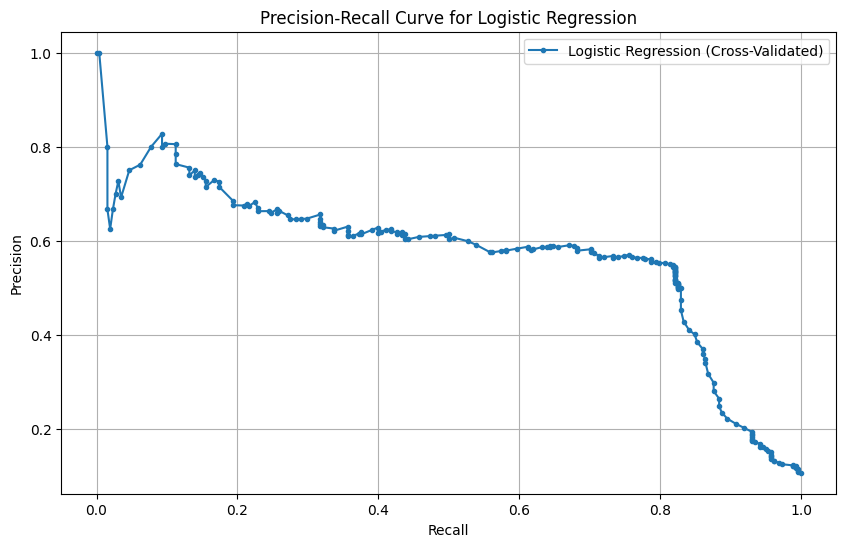

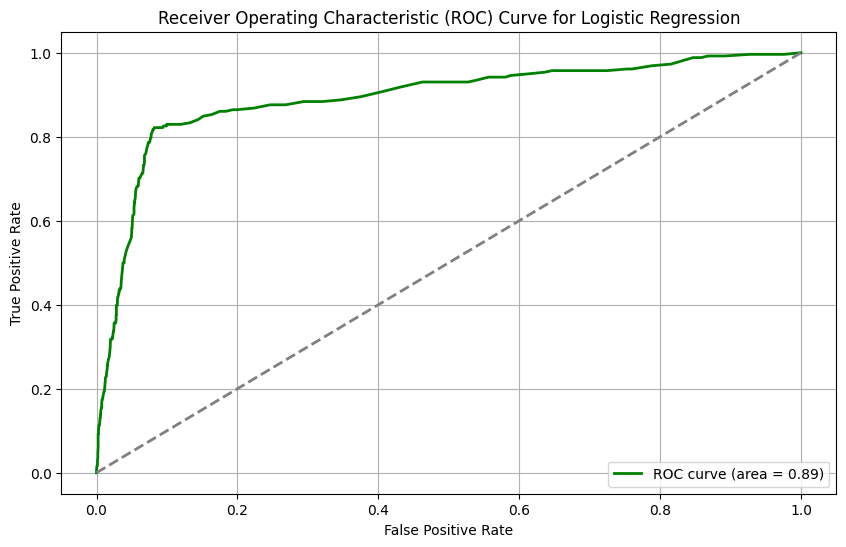

In [50]:
# Get the decision scores for the cross-validated predictions
y_scores_log_reg_cv = cross_val_predict(log_reg, X, y_train, cv=5, method='predict_proba')[:, 1]

# Calculate precision and recall values
precision_log_reg, recall_log_reg, thresholds_log_reg = precision_recall_curve(y_train, y_scores_log_reg_cv)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_log_reg, precision_log_reg, marker='.', label='Logistic Regression (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_log_reg, tpr_log_reg, roc_thresholds_log_reg = roc_curve(y_train, y_scores_log_reg_cv)

# Calculate the AUC (Area Under the Curve)
roc_auc_log_reg = auc(fpr_log_reg, tpr_log_reg)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_log_reg, tpr_log_reg, color='green', lw=2, label=f'ROC curve (area = {roc_auc_log_reg:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Logistic Regression')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# SGDClassifier

In [51]:
# Create the SGDClassifier model
sgd_clf = SGDClassifier(random_state=42)

# Perform cross-validation predictions
y_train_pred_cv_sgd = cross_val_predict(sgd_clf, X, y_train, cv=5)

# Calculate cross-validated scores
precision_cv_sgd = precision_score(y_train, y_train_pred_cv_sgd)
recall_cv_sgd = recall_score(y_train, y_train_pred_cv_sgd)
f1_cv_sgd = f1_score(y_train, y_train_pred_cv_sgd)

print(f"Cross-Validated Precision: {precision_cv_sgd:.4f}")
print(f"Cross-Validated Recall: {recall_cv_sgd:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_sgd:.4f}")

Cross-Validated Precision: 0.6135
Cross-Validated Recall: 0.3876
Cross-Validated F1 Score: 0.4751


bad

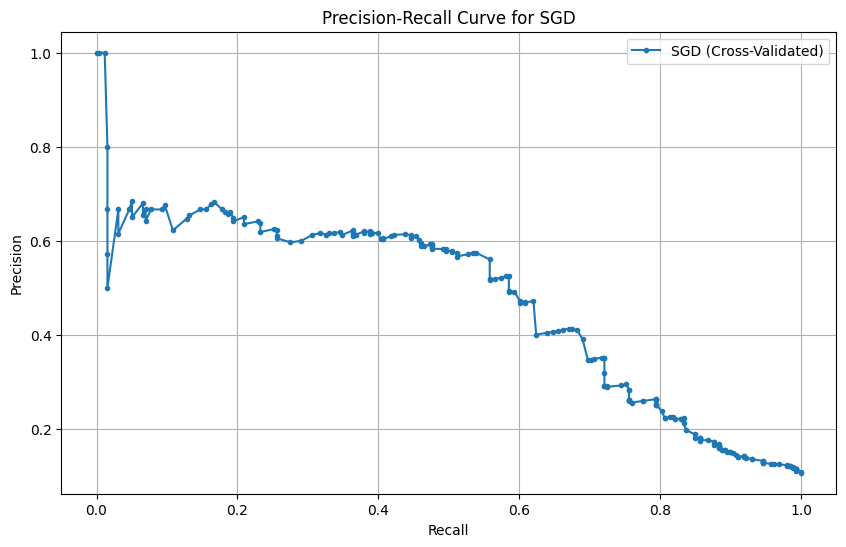

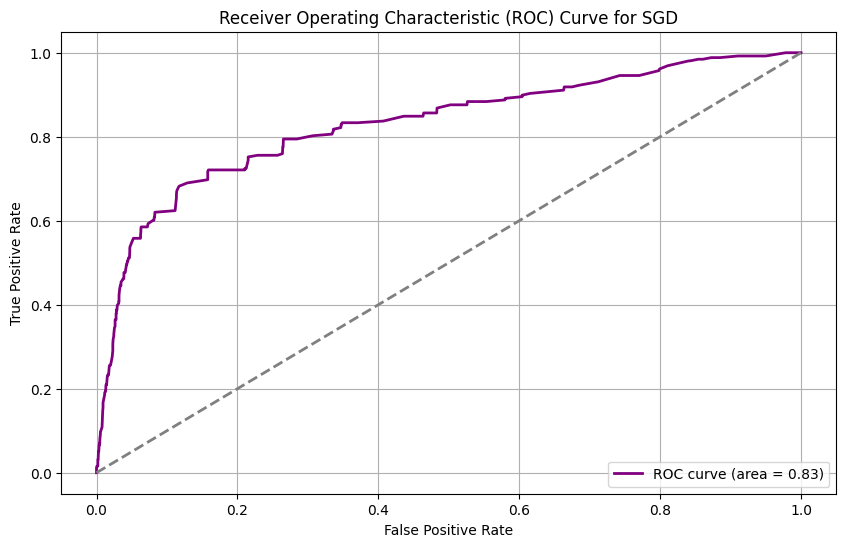

In [52]:
# Get the decision scores for the cross-validated predictions
y_scores_sgd_cv = cross_val_predict(sgd_clf, X, y_train, cv=5, method='decision_function')

# Calculate precision and recall values
precision_sgd, recall_sgd, thresholds_sgd = precision_recall_curve(y_train, y_scores_sgd_cv)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_sgd, precision_sgd, marker='.', label='SGD (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for SGD')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_sgd, tpr_sgd, roc_thresholds_sgd = roc_curve(y_train, y_scores_sgd_cv)

# Calculate the AUC (Area Under the Curve)
roc_auc_sgd = auc(fpr_sgd, tpr_sgd)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_sgd, tpr_sgd, color='purple', lw=2, label=f'ROC curve (area = {roc_auc_sgd:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SGD')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Decision Trees

In [53]:
# Create the DecisionTreeClassifier
dt_clf = DecisionTreeClassifier(random_state=42)

# Perform cross-validation predictions
y_train_pred_cv_dt = cross_val_predict(dt_clf, X, y_train, cv=5)

# Calculate cross-validated scores
precision_cv_dt = precision_score(y_train, y_train_pred_cv_dt)
recall_cv_dt = recall_score(y_train, y_train_pred_cv_dt)
f1_cv_dt = f1_score(y_train, y_train_pred_cv_dt)

print(f"Cross-Validated Precision: {precision_cv_dt:.4f}")
print(f"Cross-Validated Recall: {recall_cv_dt:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_dt:.4f}")

Cross-Validated Precision: 0.6416
Cross-Validated Recall: 0.5620
Cross-Validated F1 Score: 0.5992


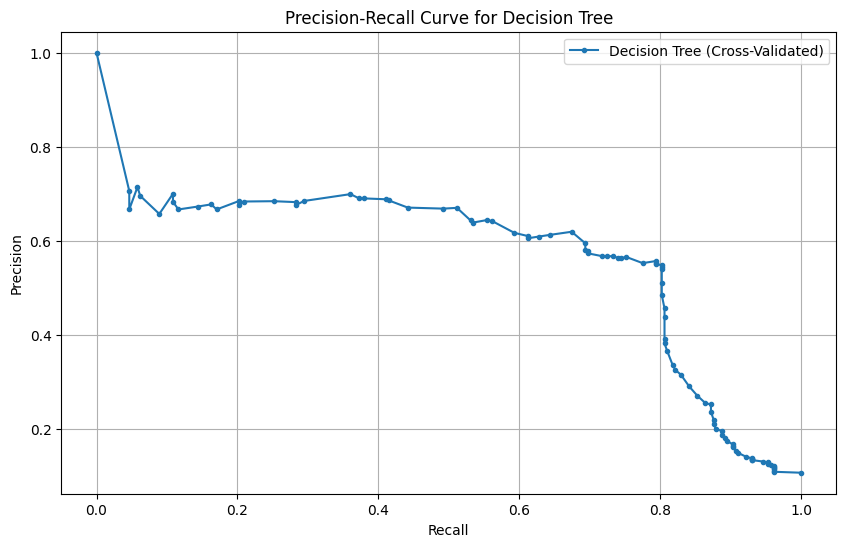

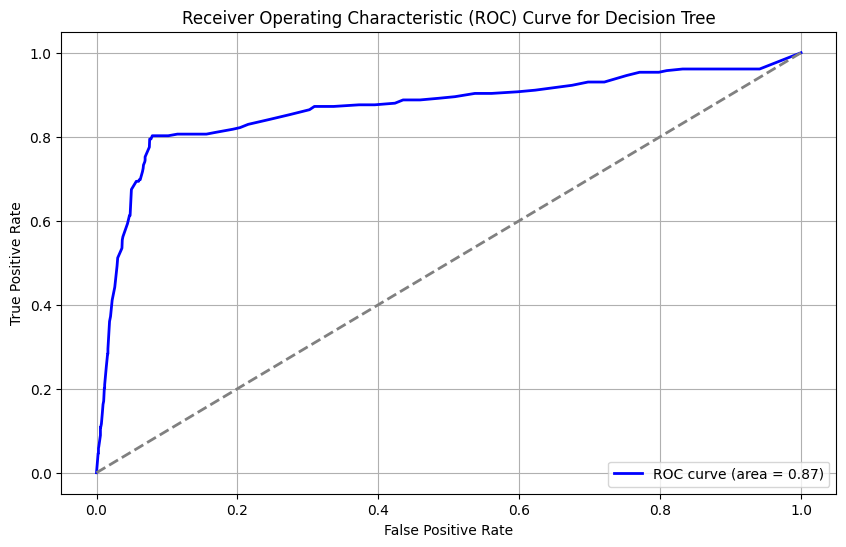

In [54]:
# Get the decision scores for the cross-validated predictions
y_scores_dt_cv = cross_val_predict(dt_clf, X, y_train, cv=5, method='predict_proba')[:, 1]

# Calculate precision and recall values
precision_dt, recall_dt, thresholds_dt = precision_recall_curve(y_train, y_scores_dt_cv)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_dt, precision_dt, marker='.', label='Decision Tree (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Decision Tree')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_dt, tpr_dt, roc_thresholds_dt = roc_curve(y_train, y_scores_dt_cv)

# Calculate the AUC (Area Under the Curve)
roc_auc_dt = auc(fpr_dt, tpr_dt)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_dt, tpr_dt, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_dt:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Decision Tree')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Linear SVC

In [55]:
# Create the LinearSVC model
linear_svc = LinearSVC(random_state=42, max_iter=10000)

# Perform cross-validation predictions
y_train_pred_cv_linear_svc = cross_val_predict(linear_svc, X, y_train, cv=5)

# Calculate cross-validated scores
precision_cv_linear_svc = precision_score(y_train, y_train_pred_cv_linear_svc)
recall_cv_linear_svc = recall_score(y_train, y_train_pred_cv_linear_svc)
f1_cv_linear_svc = f1_score(y_train, y_train_pred_cv_linear_svc)

print(f"Cross-Validated Precision: {precision_cv_linear_svc:.4f}")
print(f"Cross-Validated Recall: {recall_cv_linear_svc:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_linear_svc:.4f}")

Cross-Validated Precision: 0.5985
Cross-Validated Recall: 0.6124
Cross-Validated F1 Score: 0.6054


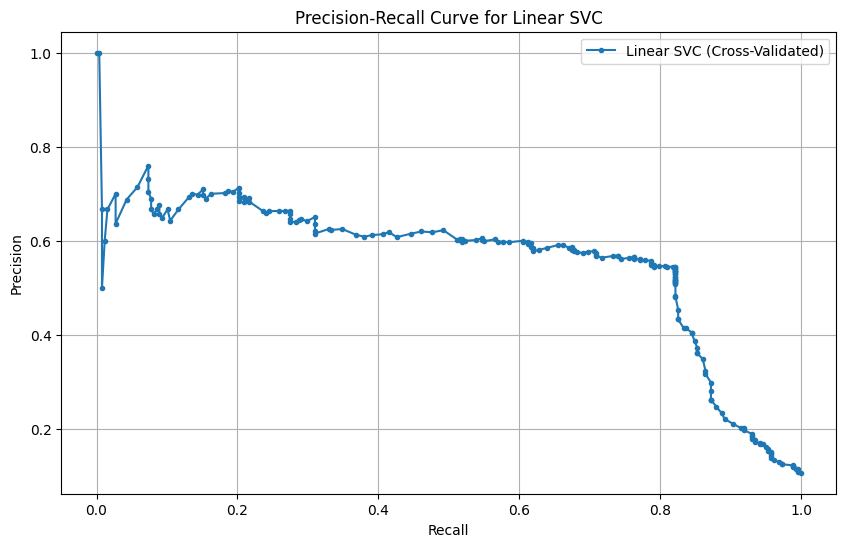

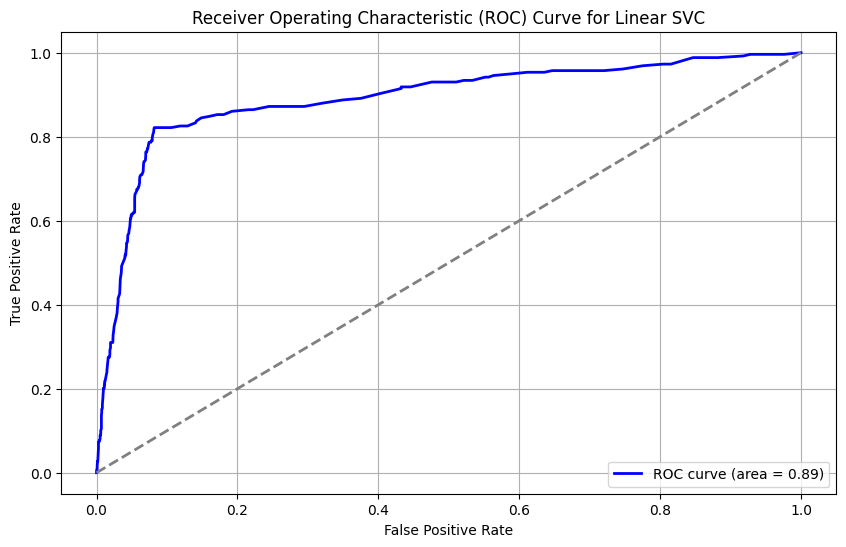

In [56]:
# Get the decision scores for the cross-validated predictions
y_scores_linear_svc_cv = cross_val_predict(linear_svc, X, y_train, cv=5, method='decision_function')

# Calculate precision and recall values
precision_linear_svc, recall_linear_svc, thresholds_linear_svc = precision_recall_curve(y_train, y_scores_linear_svc_cv)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_linear_svc, precision_linear_svc, marker='.', label='Linear SVC (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Linear SVC')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_linear_svc, tpr_linear_svc, roc_thresholds_linear_svc = roc_curve(y_train, y_scores_linear_svc_cv)

# Calculate the AUC (Area Under the Curve)
roc_auc_linear_svc = auc(fpr_linear_svc, tpr_linear_svc)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_linear_svc, tpr_linear_svc, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_linear_svc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Linear SVC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# K-Neighbors Classifier

In [57]:
# Create the KNeighborsClassifier model
knn_clf = KNeighborsClassifier()

# Perform cross-validation predictions
y_train_pred_cv_knn = cross_val_predict(knn_clf, X, y_train, cv=5)

# Calculate cross-validated scores
precision_cv_knn = precision_score(y_train, y_train_pred_cv_knn)
recall_cv_knn = recall_score(y_train, y_train_pred_cv_knn)
f1_cv_knn = f1_score(y_train, y_train_pred_cv_knn)

print(f"Cross-Validated Precision: {precision_cv_knn:.4f}")
print(f"Cross-Validated Recall: {recall_cv_knn:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_knn:.4f}")

Cross-Validated Precision: 0.6311
Cross-Validated Recall: 0.5504
Cross-Validated F1 Score: 0.5880


Looks ok

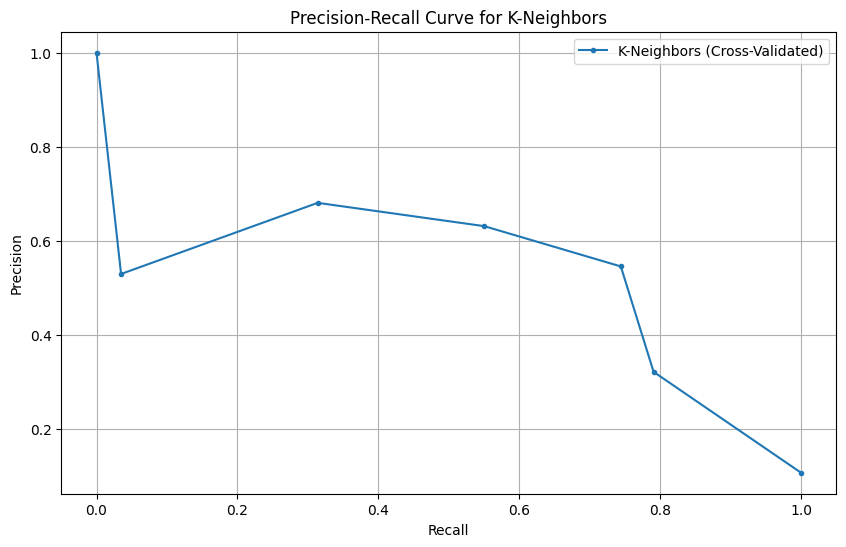

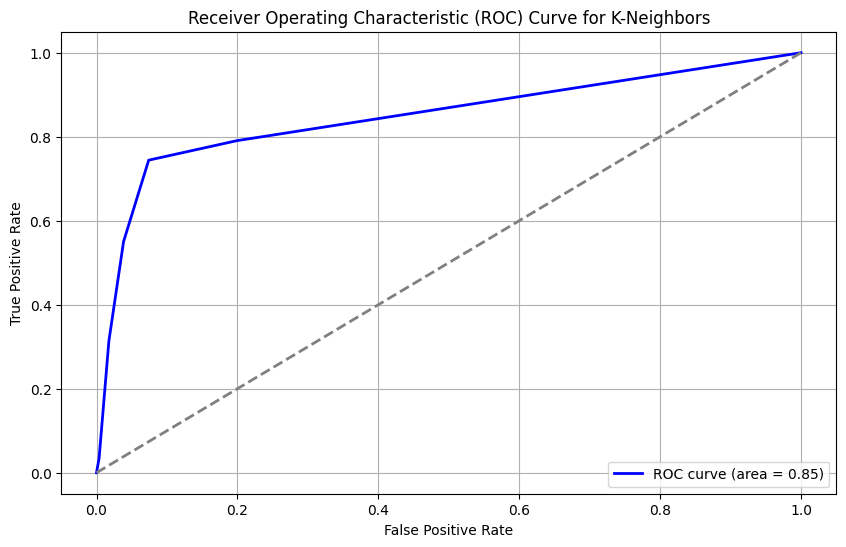

In [58]:
# Get the decision scores for the cross-validated predictions
y_scores_knn_cv = cross_val_predict(knn_clf, X, y_train, cv=5, method='predict_proba')[:, 1]

# Calculate precision and recall values
precision_knn, recall_knn, thresholds_knn = precision_recall_curve(y_train, y_scores_knn_cv)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_knn, precision_knn, marker='.', label='K-Neighbors (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for K-Neighbors')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_knn, tpr_knn, roc_thresholds_knn = roc_curve(y_train, y_scores_knn_cv)

# Calculate the AUC (Area Under the Curve)
roc_auc_knn = auc(fpr_knn, tpr_knn)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_knn, tpr_knn, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_knn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for K-Neighbors')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Radius Neighbors Classifier

In [59]:

# Create the RadiusNeighborsClassifier with a smaller radius and handle outliers
radius_neighbors_clf = RadiusNeighborsClassifier(radius=1.0) 

# Perform cross-validation predictions
y_train_pred_cv_rn = cross_val_predict(radius_neighbors_clf, X, y_train, cv=5)

# Calculate cross-validated scores
precision_cv_rn = precision_score(y_train, y_train_pred_cv_rn, zero_division=1)
recall_cv_rn = recall_score(y_train, y_train_pred_cv_rn, zero_division=1)
f1_cv_rn = f1_score(y_train, y_train_pred_cv_rn)

print(f"Cross-Validated Precision: {precision_cv_rn:.4f}")
print(f"Cross-Validated Recall: {recall_cv_rn:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_rn:.4f}")

Cross-Validated Precision: 0.6318
Cross-Validated Recall: 0.4922
Cross-Validated F1 Score: 0.5534


Bad

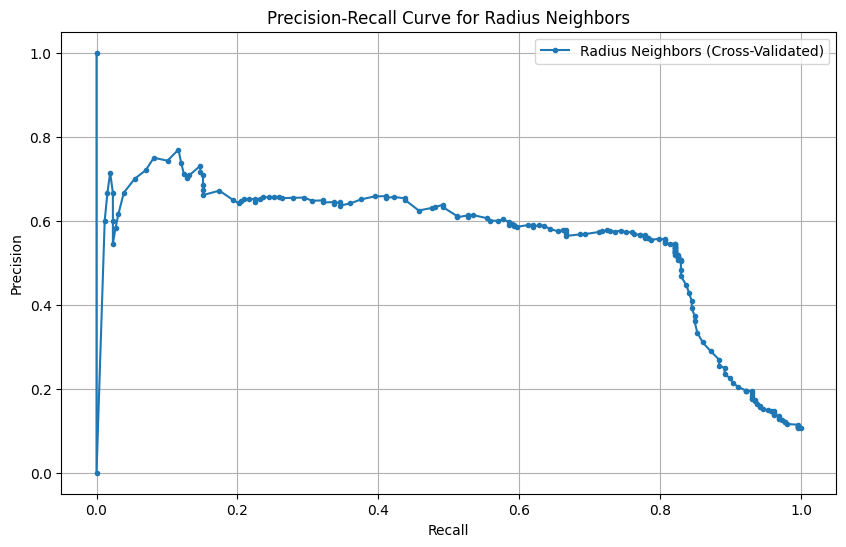

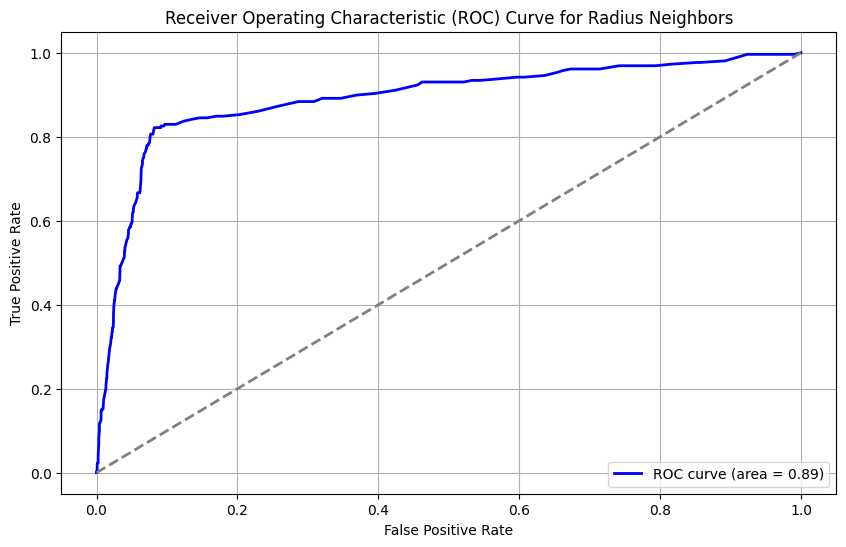

In [60]:
# Get the decision scores for the cross-validated predictions
y_scores_rn_cv = cross_val_predict(radius_neighbors_clf, X, y_train, cv=5, method='predict_proba')[:, 1]

# Calculate precision and recall values
precision_rn, recall_rn, thresholds_rn = precision_recall_curve(y_train, y_scores_rn_cv)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_rn, precision_rn, marker='.', label='Radius Neighbors (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Radius Neighbors')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_rn, tpr_rn, roc_thresholds_rn = roc_curve(y_train, y_scores_rn_cv)

# Calculate the AUC (Area Under the Curve)
roc_auc_rn = auc(fpr_rn, tpr_rn)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_rn, tpr_rn, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_rn:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Radius Neighbors')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# SVC Classifier

In [61]:


# Create the SVC model
svc_clf = SVC(probability=True, random_state=42)

# Perform cross-validation predictions
y_train_pred_cv_svc = cross_val_predict(svc_clf, X, y_train, cv=5)

# Calculate cross-validated scores
precision_cv_svc = precision_score(y_train, y_train_pred_cv_svc)
recall_cv_svc = recall_score(y_train, y_train_pred_cv_svc)
f1_cv_svc = f1_score(y_train, y_train_pred_cv_svc)

print(f"Cross-Validated Precision: {precision_cv_svc:.4f}")
print(f"Cross-Validated Recall: {recall_cv_svc:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_svc:.4f}")

Cross-Validated Precision: 0.5673
Cross-Validated Recall: 0.5388
Cross-Validated F1 Score: 0.5527


Not Great

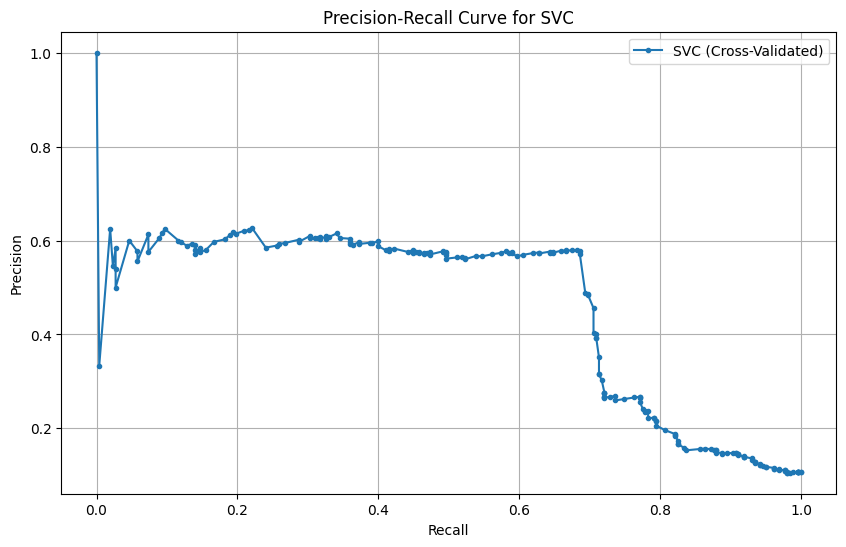

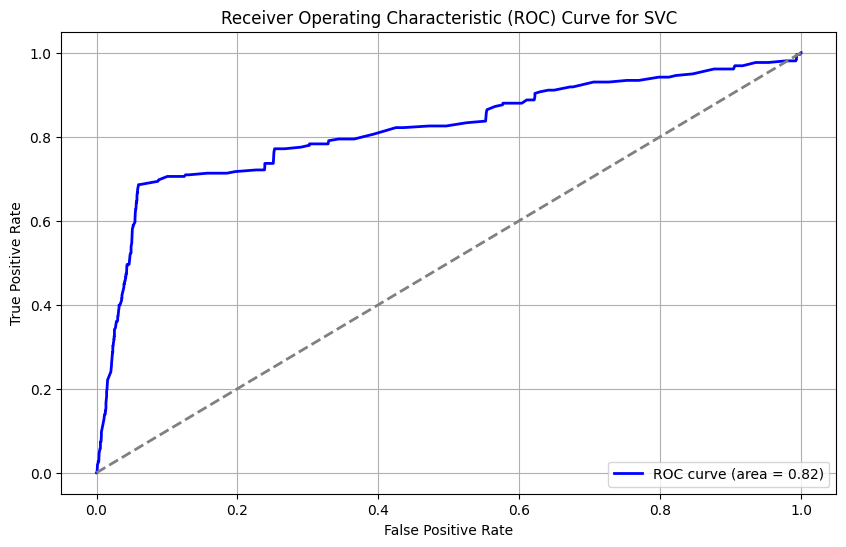

In [62]:
# Get the decision scores for the cross-validated predictions
y_scores_svc_cv = cross_val_predict(svc_clf, X, y_train, cv=5, method='predict_proba')[:, 1]

# Calculate precision and recall values
precision_svc, recall_svc, thresholds_svc = precision_recall_curve(y_train, y_scores_svc_cv)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_svc, precision_svc, marker='.', label='SVC (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for SVC')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_svc, tpr_svc, roc_thresholds_svc = roc_curve(y_train, y_scores_svc_cv)

# Calculate the AUC (Area Under the Curve)
roc_auc_svc = auc(fpr_svc, tpr_svc)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_svc, tpr_svc, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_svc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for SVC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Linear SVC

In [63]:
# Create the LinearSVC classifier
linear_svc = LinearSVC(random_state=42, max_iter=10000)

# Fit the model to the training data
linear_svc.fit(X, y_train)

# Predict on the training data
y_train_pred = linear_svc.predict(X)

# Calculate the F1 score on the training data
train_f1_score = f1_score(y_train, y_train_pred)

# Perform cross-validation
cv_scores = cross_val_score(linear_svc, X, y_train, cv=5, scoring='f1')

# Perform cross-validation predictions
y_train_pred_cv = cross_val_predict(linear_svc, X, y_train, cv=5)

# Calculate cross-validated scores
accuracy_cv = accuracy_score(y_train, y_train_pred_cv)
precision_cv = precision_score(y_train, y_train_pred_cv)
recall_cv = recall_score(y_train, y_train_pred_cv)
f1_cv = f1_score(y_train, y_train_pred_cv)

print(f"Cross-Validated Precision: {precision_cv:.4f}")
print(f"Cross-Validated Recall: {recall_cv:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv:.4f}")

Cross-Validated Precision: 0.5985
Cross-Validated Recall: 0.6124
Cross-Validated F1 Score: 0.6054


Ok

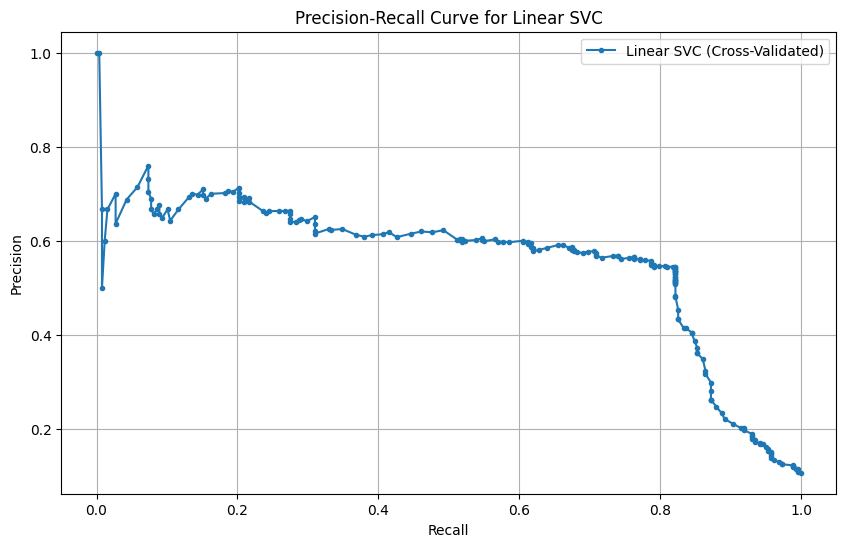

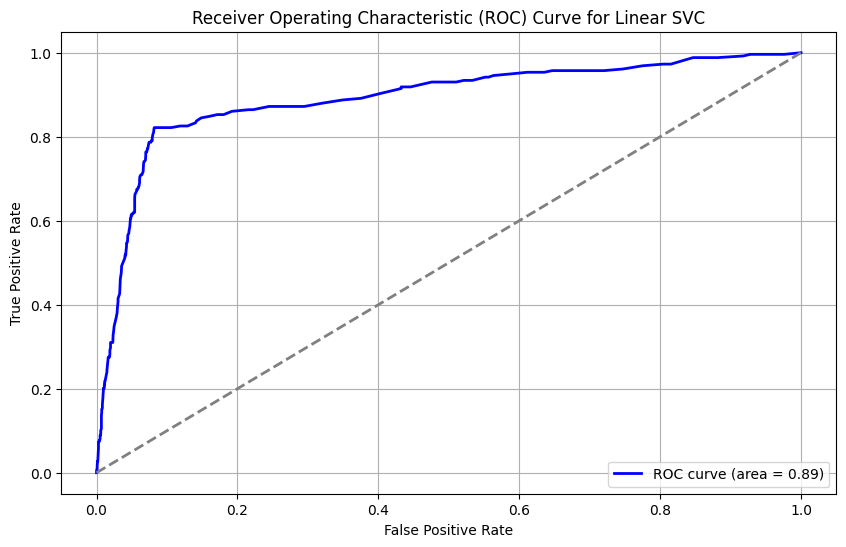

In [64]:
# Get the decision scores for the cross-validated predictions
y_scores_svc_cv = cross_val_predict(linear_svc, X, y_train, cv=5, method='decision_function')

# Calculate precision and recall values
precision_svc, recall_svc, thresholds_svc = precision_recall_curve(y_train, y_scores_svc_cv)

# Plot the Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall_svc, precision_svc, marker='.', label='Linear SVC (Cross-Validated)')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve for Linear SVC')
plt.legend()
plt.grid(True)
plt.show()

# Calculate the ROC curve
fpr_svc, tpr_svc, roc_thresholds_svc = roc_curve(y_train, y_scores_svc_cv)

# Calculate the AUC (Area Under the Curve)
roc_auc_svc = auc(fpr_svc, tpr_svc)

# Plot the ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_svc, tpr_svc, color='blue', lw=2, label=f'ROC curve (area = {roc_auc_svc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve for Linear SVC')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Logistic Regression Fine Tuning

In [65]:
# write grid search for logistic regression

# Create the LogisticRegression model
log_reg = LogisticRegression(random_state=42, max_iter=1000)

# Define the parameter grid for GridSearchCV

param_grid = {
    'C': [0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],  
    'penalty': ['l2'], 
    'class_weight': ['balanced'],
    'max_iter': [1000, 2000, 3000] 
}

# Define the scoring metric
scoring = make_scorer(precision_score)

# Create the GridSearchCV object

grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, scoring=scoring, cv=5, n_jobs=-1)

# Fit the GridSearchCV object to the training data
grid_search.fit(X, y_train)

#print best precision

print(f"Best Parameters: {grid_search.best_params_}")

print(f"Best Score: {grid_search.best_score_}")

Best Parameters: {'C': 100.0, 'class_weight': 'balanced', 'max_iter': 1000, 'penalty': 'l2'}
Best Score: 0.5450167672702885


In [66]:
# Best ridge regression model

# Create the LogisticRegression with the best parameters
best_log_reg = LogisticRegression(
    C=100.0,
    class_weight='balanced',
    penalty='l2',
    random_state=42,
    max_iter=1000
)

# Perform cross-validation predictions to get predicted probabilities
y_train_pred_proba = cross_val_predict(best_log_reg, X, y_train, cv=5, method='predict_proba')

# Select the probabilities for the positive class (index 1)
y_train_pred_proba_pos_class = y_train_pred_proba[:, 1]

# Set a higher threshold, e.g., 0.7
threshold = 0.5
y_train_pred_cv = (y_train_pred_proba_pos_class >= threshold).astype(int)

# Calculate cross-validated scores
precision_cv = precision_score(y_train, y_train_pred_cv)
recall_cv = recall_score(y_train, y_train_pred_cv)
f1_cv = f1_score(y_train, y_train_pred_cv)

print(f"Cross-Validated Precision: {precision_cv:.4f}")
print(f"Cross-Validated Recall: {recall_cv:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv:.4f}")

Cross-Validated Precision: 0.5422
Cross-Validated Recall: 0.8217
Cross-Validated F1 Score: 0.6533


# Gradient Boosting Fine-Tuning

In [67]:
# random search for gradient boosting

# Create the GradientBoostingClassifier

gb_clf = GradientBoostingClassifier(random_state=42)

# Define the parameter grid for RandomizedSearchCV

param_distributions = {
    'n_estimators': [50, 100, 150, 200, 250, 300, 350, 400, 450, 500], 
    'max_depth': [3, 5, 7, 9, 11, 13, 15, 17, 19,21,23,25,27,29],  
    'min_samples_split': [2, 5, 10, 15, 20, 25, 30,35,40,45,50], 
    'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],  
    'max_features': ['auto', 'sqrt', 'log2'],  
    'learning_rate': [0.01, 0.1, 1.0],  
    'subsample': [0.5, 0.75, 1.0] 
}

# Create the RandomizedSearchCV object

scoring = make_scorer(f1_score)

random_search = RandomizedSearchCV(estimator=gb_clf, param_distributions=param_distributions, n_iter=100, scoring=scoring, cv=5, n_jobs=-1, random_state=42)

# Fit the RandomizedSearchCV object to the training data

random_search.fit(X, y_train)

# Print the best parameters and best score

print(f"Best Parameters: {random_search.best_params_}")
print(f"Best Score: {random_search.best_score_}")



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
210 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12

Best Parameters: {'subsample': 1.0, 'n_estimators': 350, 'min_samples_split': 20, 'min_samples_leaf': 18, 'max_features': 'log2', 'max_depth': 13, 'learning_rate': 0.01}
Best Score: 0.624149853899417


In [68]:
from sklearn.ensemble import GradientBoostingClassifier

# Define the model
model = GradientBoostingClassifier(random_state=42)

# Define the parameter grid
param_grid = {
    'n_estimators': [300, 350, 400], 
    'max_depth': [11, 13, 15],  
    'min_samples_split': [15, 20, 25],  
    'min_samples_leaf': [16, 18, 20],  
    'max_features': ['log2'],  
    'learning_rate': [0.01, 0.05],  
    'subsample': [1.0]  
}


scoring = make_scorer(f1_score)

# Use GridSearchCV with the custom scorer
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring=scoring,
    cv=5,
    n_jobs=-1,
    verbose=0
)

# Fit the model
grid_search.fit(X, y_train)

# Output the best parameters and score
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Score: {grid_search.best_score_}")

Best Parameters: {'learning_rate': 0.01, 'max_depth': 11, 'max_features': 'log2', 'min_samples_leaf': 18, 'min_samples_split': 15, 'n_estimators': 400, 'subsample': 1.0}
Best Score: 0.6266404781575836


In [69]:

# Create the GradientBoostingClassifier with the best parameters
best_gb_clf = GradientBoostingClassifier(
    learning_rate=0.01,
    max_depth=11,
    max_features='log2',
    min_samples_leaf=18,
    min_samples_split=15,
    n_estimators=400,
    subsample=1.0,
    random_state=42
)


# Fit the model to the training data
best_gb_clf.fit(X, y_train)

# Perform cross-validation predictions to get predicted probabilities
y_train_pred_proba_gb = cross_val_predict(best_gb_clf, X, y_train, cv=5, method='predict_proba')

# Select the probabilities for the positive class (class 1)
y_train_pred_proba_pos_class = y_train_pred_proba_gb[:, 1]

threshold = 0.5
y_train_pred_cv_gb = (y_train_pred_proba_pos_class >= threshold).astype(int)

# Calculate cross-validated scores
precision_cv_gb = precision_score(y_train, y_train_pred_cv_gb)
recall_cv_gb = recall_score(y_train, y_train_pred_cv_gb)
f1_cv_gb = f1_score(y_train, y_train_pred_cv_gb)

print(f"Cross-Validated Precision: {precision_cv_gb:.4f}")
print(f"Cross-Validated Recall: {recall_cv_gb:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_gb:.4f}")

Cross-Validated Precision: 0.6314
Cross-Validated Recall: 0.6240
Cross-Validated F1 Score: 0.6277


Not bad for gradient boosting in the context of the problem.

# Random Forests Fine-Tuning

In [70]:

# Define the parameter grid for RandomizedSearchCV
param_grid = {
    'n_estimators': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70],
    'max_depth': [10 ,15,20,25, 30, 35, 40, 45, 50],
    'min_samples_split': [35, 40, 45, 50, 55, 60, 65, 70, 75],
    'min_samples_leaf': [1, 2, 3, 4, 8, 10, 12, 14, 16],
    'max_features': ['sqrt', 'log2'],
    'bootstrap': [True],
    'class_weight': ['balanced']
}

# Define the scoring metric
scoring = make_scorer(f1_score)

# Define the cross-validation strategy
cv = StratifiedKFold(n_splits=10, random_state=42, shuffle=True)

# Create the RandomizedSearchCV object
random_search = RandomizedSearchCV(
    estimator=rf_clf, 
    param_distributions=param_grid, 
    n_iter=20, 
    scoring=scoring, 
    cv=cv, 
    random_state=42, 
    n_jobs=-1, 
    verbose=0
)

# Fit the random search model
random_search.fit(X, y_train)

# Get the best estimator
best_rf_clf = random_search.best_estimator_

# Print the best parameters
print("Best parameters found: ", random_search.best_params_)

Best parameters found:  {'n_estimators': 50, 'min_samples_split': 35, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 20, 'class_weight': 'balanced', 'bootstrap': True}


In [71]:
# grid search for random forest

# Define the parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 55, 60],  
    'max_depth': [20, 25, 30],  
    'min_samples_split': [35, 40],  
    'min_samples_leaf': [2, 3],  
    'max_features': ['sqrt', 'log2'],  
    'bootstrap': [True],  
    'class_weight': ['balanced']  
}

# Define the scoring metric
scoring = make_scorer(f1_score)
# Create the GridSearchCV object
grid_search = GridSearchCV(
    estimator=rf_clf, 
    param_grid=param_grid, 
    scoring=scoring, 
    cv=cv, 
    n_jobs=-1, 
    verbose=0
)

# Fit the grid search model
grid_search.fit(X, y_train)

# Get the best estimator
best_rf_clf = grid_search.best_estimator_

# Print the best parameters
print("Best parameters found: ", grid_search.best_params_)
print("Best score found: ", grid_search.best_score_)




Best parameters found:  {'bootstrap': True, 'class_weight': 'balanced', 'max_depth': 20, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 35, 'n_estimators': 50}
Best score found:  0.6513314283936738


In [72]:

# Create the RandomForestClassifier
rf_clf = RandomForestClassifier(random_state=42, n_estimators=50, min_samples_split=35, min_samples_leaf=3, max_features='sqrt', max_depth=20, class_weight='balanced', bootstrap=True)

# Perform cross-validation predictions to get predicted probabilities
y_train_pred_proba_rf = cross_val_predict(rf_clf, X, y_train, cv=5, method='predict_proba')

# Select the probabilities for the positive class (index 1)
y_train_pred_proba_rf_pos_class = y_train_pred_proba_rf[:, 1]

threshold = .86
y_train_pred_cv_rf = (y_train_pred_proba_rf_pos_class >= threshold).astype(int)

# Calculate cross-validated scores
precision_cv_rf = precision_score(y_train, y_train_pred_cv_rf)
recall_cv_rf = recall_score(y_train, y_train_pred_cv_rf)
f1_cv_rf = f1_score(y_train, y_train_pred_cv_rf)

print(f"Cross-Validated Precision: {precision_cv_rf:.4f}")
print(f"Cross-Validated Recall: {recall_cv_rf:.4f}")
print(f"Cross-Validated F1 Score: {f1_cv_rf:.4f}")

Cross-Validated Precision: 0.6013
Cross-Validated Recall: 0.7016
Cross-Validated F1 Score: 0.6476


In [66]:
# import confusion matrix
from sklearn.metrics import confusion_matrix

# Get the confusion matrix
conf_matrix = confusion_matrix(y_train, y_train_pred_cv_rf)

# Create a DataFrame
conf_matrix_df = pd.DataFrame(conf_matrix, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])

# Display the confusion matrix
conf_matrix_df

,Predicted Negative,Predicted Positive
Actual Negative,2040,120
Actual Positive,77,181


# Model

We wanted to identify a balance between recall and precision within our model so that we can account for your current lack of resources, while also making sure that this model is effective if you end up getting access to more resources.

We chose to focus on f1 score when running our grid and random searches, with the idea that we would identify the best and most balenced model, and then adjust the threshold to increase the precision because our precision in most of our models was lacking compared to the recall.

We checked out many different classification models, ranging from SVC to logisitc regression. Most of them did not give us very good scores, however there were 3 taht we wanted to take a deeper look into

- Logistic Regression
- Gradient Boosting
- Random Forest

Out of these models we ran 3 different grid searches. 

Logistic Regression:
- Low Precision (0.54)
- High Recall (0.82)
- F1 score (0.65)
- Not good because precision would not be good for a low resources company.

Gradient Boosting: 
- Average Precision (0.63)
- Average Recall (0.62)
- F1 Score (0.62)
- Not great, but also not terrible in the context of the problem

Random Forest:
- Precision (0.6)
- Recall (0.7)
- F1 Score (0.64)
- Very good compared to others in our opinion. It does a pretty good job accounting for both the resources of the company, but also wanting to identify most diseased squirrels.




Final Presentation
=========

Central Park is facing a problem with its squirrels, an important part of the park's ecosystem. There’s concern that some squirrels may be sick, and if the disease spreads, it could harm the population and disrupt the environment.

The goal of this project is to create a tool that predicts if a squirrel is sick based on sightings. This will help park staff quickly respond and prevent the spread of disease.

We’ll use data from October 2018. The data used involves Central Park, NY squirrel census, weather information, and reports from park rangers to make accurate predictions. The park staff wants to make sure every sick squirrel is identified, even if it means a few false alarms.

Our final product will provide real-time updates and simple visuals to help the team take action. This tool will help keep the squirrels healthy and protect the park’s ecosystem.

### Our Process
For this project, we analyzed where sick squirrels were most commonly seen by grouping their locations into clusters. This helped us understand "hotspots" where the squirrels might need the most attention, and we used this information to improve our predictions.

We also looked at weather data for Central Park to see if things like temperature or rain were connected to squirrel health, but we didn’t find any meaningful patterns there. Interestingly, the squirrels’ fur color turned out to be very important, it had a strong connection to whether a squirrel was likely to be sick. This insight was really helpful in building our tool.

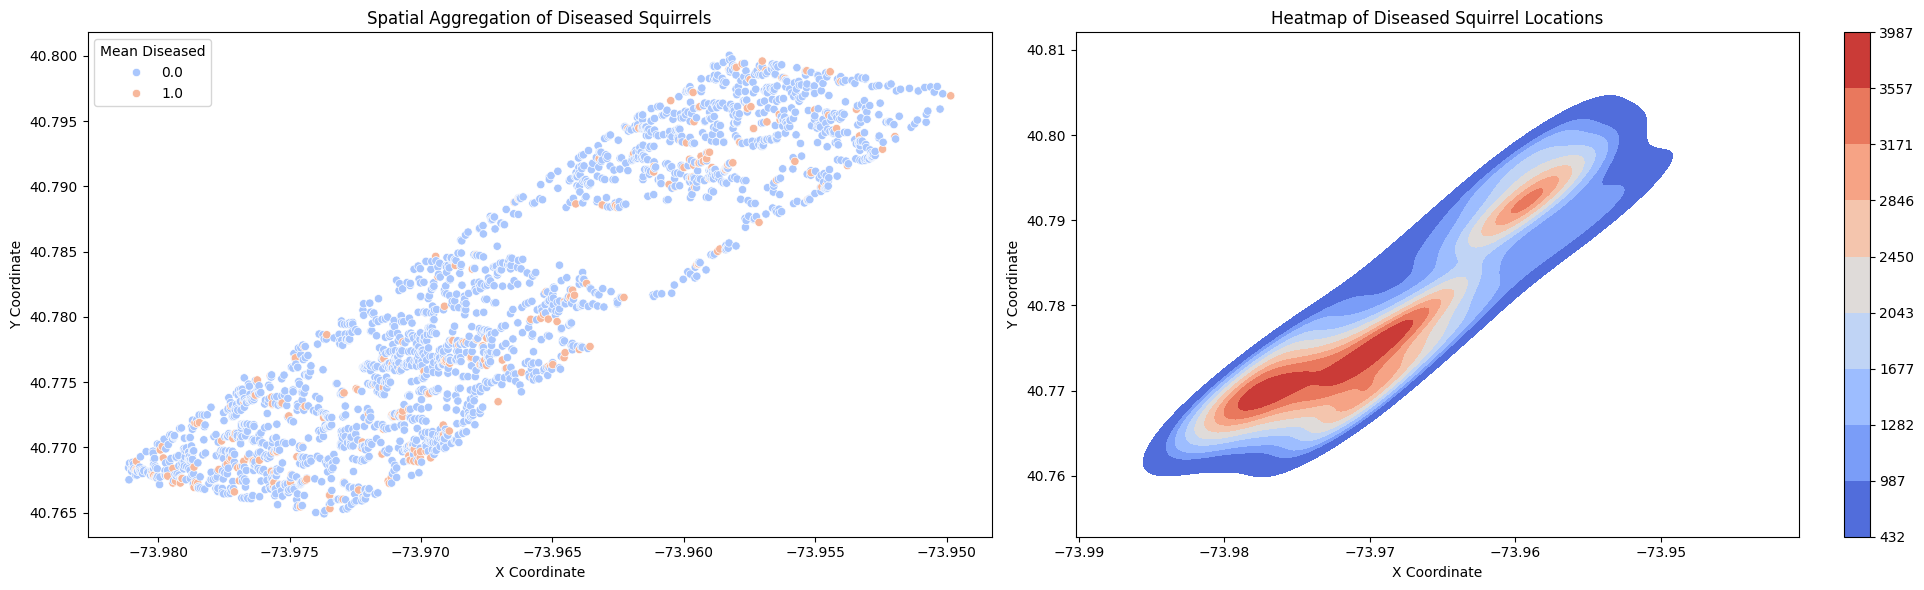

In [73]:
# Group by spatial coordinates and calculate the mean of the target label
spatial_aggregation = train.groupby(['X', 'Y'])['Diseased'].mean().reset_index()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot the spatial aggregation to visualize the correlation
sns.scatterplot(data=spatial_aggregation, x='X', y='Y', hue='Diseased', palette='coolwarm', legend='full', ax=axes[0])
axes[0].set_title('Spatial Aggregation of Diseased Squirrels')
axes[0].set_xlabel('X Coordinate')
axes[0].set_ylabel('Y Coordinate')
axes[0].legend(title='Mean Diseased')

# Filter the data to include only diseased squirrels
diseased_squirrels = train[train['Diseased'] == 1]

# Create a heatmap of the locations of diseased squirrels
sns.kdeplot(data=diseased_squirrels, x='X', y='Y', fill=True, cmap='coolwarm', cbar=True, ax=axes[1])
axes[1].set_title('Heatmap of Diseased Squirrel Locations')
axes[1].set_xlabel('X Coordinate')
axes[1].set_ylabel('Y Coordinate')

plt.tight_layout()
plt.show()

### Documentation for the Graphs

#### Left Graph:
This graph shows where squirrels were spotted in Central Park, marked by their locations (X and Y coordinates). The colors indicate whether a squirrel was healthy or diseased. Healthy squirrels are shown in blue, while diseased squirrels are shown in orange. This gives us a clear picture of where diseased squirrels are most concentrated within the park.

#### Right Graph:
This heatmap highlights areas in the park where diseased squirrels are more likely to be found. The warmer colors (red and orange) represent locations with a higher number of sightings of diseased squirrels, while cooler colors (blue) show areas with fewer sightings. This helps us identify "hotspots" where attention is needed the most.

### Purpose
Both graphs work together to help identify patterns in squirrel health based on their locations, showing where the problem is most concentrated. This information can guide efforts to monitor and respond to the situation in Central Park effectively.



## Conclusion

In our final model, we decidied to go with a Random Forest model that had 60% precision, and 70% recall. This means that of all the diseased squirels, 70% of them will be accounted for, and 60% of the squirrels that people are sent to check out and cure will be diseased. While this is not perfect, this is better than randomly guessing if a squirrel is diseased or not so therefore you will end up saving on resources. We could've found a higher number for recall or a higher number for precision, but based off of your current needs while still accounting for your future needs, we felt that the current model is superior. This is because for now in the short term you have a model that can more accurately predict a diseased squirrel than guessing, and you know that most of the diseased squirrels in the park are identified even if there are some false positives. Also, if your company scales higher and you are able to have more resources to hire more people to check out the squirrels, you will know most of the diseased squirrels and be able to stop the spread.

In [74]:
import pickle

# Save the preprocessor fit data to a pickle file
with open('preprocessor_fit_data.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)

In [75]:
with open('final_model.pkl', 'wb') as file:
    pickle.dump(rf_clf, file)